---
title: "Analiza Danych oraz Predykcja ITS i Chlorofilu A"
author: 
    - name: "Bartosz Kogutowicz"
    - name: "Jakub Jaśkiewicz"
date: now
format: 
    html:
        theme: zephyr
        toc: true
        toc-depth: 3
        number-sections: true
        code-fold: true
        fig-align: center
        fig-width: 8
        fig-height: 5
        title-block-banner: true
        embed-resources: true
abstract: |
    W niniejszym sprawozdaniu przedstawiono analizę danych dotyczących ITS i Chlorofilu A. Celem analizy jest sprawdzenie możliwości predykcji wartości ITS i Chlorofilu A za pomocą regresji liniowej oraz jednej wybranej metody uczenia maszynowego (w naszym przypadku metoda SVM).
lang: pl
toc: true
execute:
    warning: false
    error: false
number-sections: true
---

::: {.callout-note}
W tworzeniu analizy i pisaniu kodu pomagał nam [GitHub Copilot](https://github.com/features/copilot), który był zintegrowany ze środowiskiem, w którym był pisany kod. W opisach wyników wspomagaliśmy się [chatem GPT](https://chatgpt.com/), aby zwiększyć efektywność naszej pracy nad projektem.
:::

## Przygotowanie Danych

Wczytanie podstawowych pakietów potrzebnych do przygotowania danych oraz analizy.

In [1]:
#| code-fold: false
# zestaw pakietów potrzebnych do zarządzania danymi
library(tidyverse)

Warning message:
"pakiet 'ggplot2' został zbudowany w wersji R 4.3.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Wczytanie danych z plików CSV.



In [2]:
#| code-fold: false
dane <- read_csv("dd.csv")
dane <- dane %>% select(-`...1`)

New names:
• `` -> `...1`
Rows: 51 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): ...1, chla, temp, bar, nas, przew, ph, namon, ITS

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Podgląd pierwszych 6 wierszy danych.

In [3]:
#| code-fold: false
head(dane)

chla,temp,bar,nas,przew,ph,namon,ITS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.1,12.0,10,80.78,176,7.40,0.100,7.64986
2.5,15.2,20,89.68,157,7.60,0.100,7.73416
8.6,19.0,5,87.50,207,8.00,0.050,8.16250
2.3,19.5,10,83.50,189,7.67,0.050,7.88450
7.5,12.0,0,108.30,122,8.20,0.004,8.09210
10.3,21.5,5,94.16,202,8.10,0.140,8.17592


Zapisanie w zmiennej nazw kolumn do analizy w celu ułatwienia pracy z danymi.

In [4]:
#| code-fold: false
kolumny_do_analizy <- c("chla", "temp", "bar", "nas", "przew", "ph", "namon", "ITS")

Sprawdzenie liczby brakujących wartości w każdej kolumnie danych. 

In [5]:
#| code-fold: false
# Ile wartości NA jest w każdej kolumnie
dane %>% summarise_all(list(~sum(is.na(.))))

chla,temp,bar,nas,przew,ph,namon,ITS
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0


Zmienna `ITS` zostanie utworzona z zmiennych już istniejących w zbiorze danych według wzoru:
$$ ITS = ph + 0.013 \cdot (100 - nas) $$

In [6]:
#| code-fold: false
# Utworzenie nowej kolumny ITS
dane$ITS <- dane$ph + 0.013 * (100 - dane$nas)

Zmienna `ITS` została skonstruowana jako liniowa kombinacja zmiennych `ph` i `nas`. W związku z tym, w modelach regresji przewidujących `ITS`, oczekujemy wysokiej jakości dopasowania i statystycznie istotnych wyników.

## Podstawowe wykresy i wizualizacje

### Podstawowe statystyki wszystkich dostępnych zmiennych

In [7]:
# Podstawowe statystyki
dane %>% select(all_of(kolumny_do_analizy)) %>% summary()

      chla            temp            bar             nas        
 Min.   : 1.10   Min.   : 8.00   Min.   : 0.00   Min.   : 42.07  
 1st Qu.: 7.90   1st Qu.:13.00   1st Qu.:10.00   1st Qu.: 89.37  
 Median :19.00   Median :16.60   Median :20.00   Median :100.43  
 Mean   :21.75   Mean   :15.96   Mean   :17.55   Mean   : 99.62  
 3rd Qu.:26.90   3rd Qu.:18.90   3rd Qu.:20.00   3rd Qu.:108.08  
 Max.   :97.00   Max.   :22.50   Max.   :40.00   Max.   :131.06  
     przew             ph            namon             ITS       
 Min.   :122.0   Min.   :7.200   Min.   :0.0000   Min.   :7.650  
 1st Qu.:176.0   1st Qu.:7.950   1st Qu.:0.1000   1st Qu.:7.995  
 Median :191.0   Median :8.290   Median :0.1000   Median :8.353  
 Mean   :201.2   Mean   :8.289   Mean   :0.1164   Mean   :8.294  
 3rd Qu.:209.5   3rd Qu.:8.700   3rd Qu.:0.1600   3rd Qu.:8.523  
 Max.   :403.0   Max.   :9.300   Max.   :0.2400   Max.   :8.945  

In [8]:
#| echo: false
library(ggplot2)

### Histogramy wszystkich zmiennych

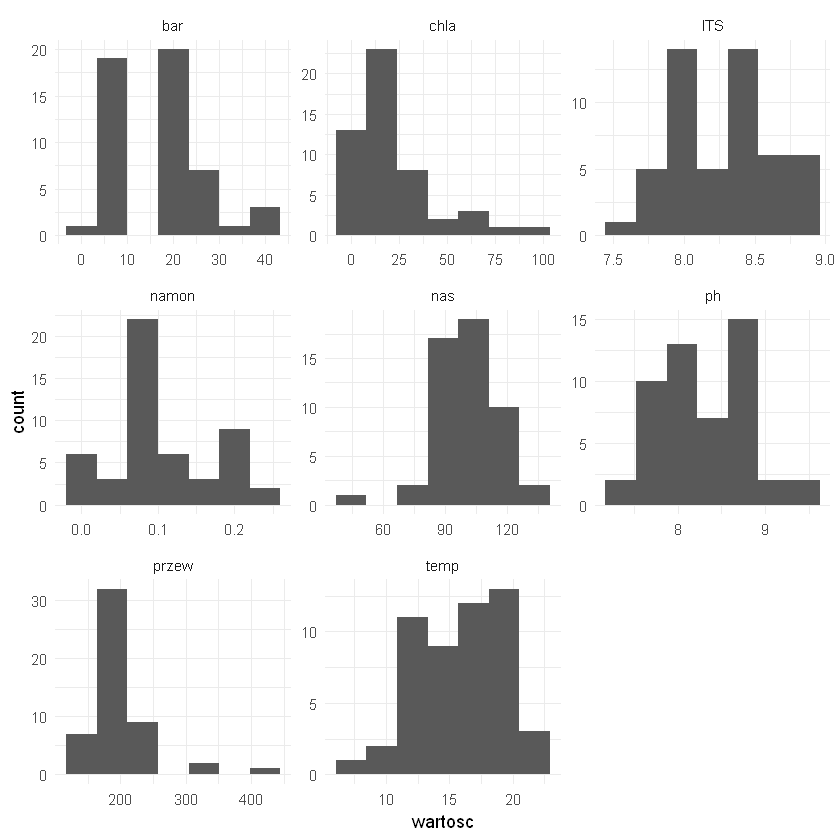

In [9]:
# histogramy z facet wrap
dane %>% gather(key = "zmienna", value = "wartosc", all_of(kolumny_do_analizy)) %>%
  ggplot(aes(x = wartosc)) +
  geom_histogram(bins = 7) +
  facet_wrap(~zmienna, scales = "free") +
  theme_minimal()

Histogramy dla wszystkich ośmiu zmiennych (`chla`, `temp`, `bar`, `nas`, `przew`, `ph`, `namon`, `ITS`) wskazują na rozkłady dzwonowate, co sugeruje, że zmienne te mogą być zbliżone do rozkładów normalnych. Każda zmienna ma swoje charakterystyczne wartości centralne i rozpiętość, jednak ich kształt pozostaje podobny: większość obserwacji koncentruje się wokół środka, z malejącą częstością w kierunku wartości skrajnych.

### Zależności między zmiennymi

Warning message:
"pakiet 'GGally' został zbudowany w wersji R 4.3.3"
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



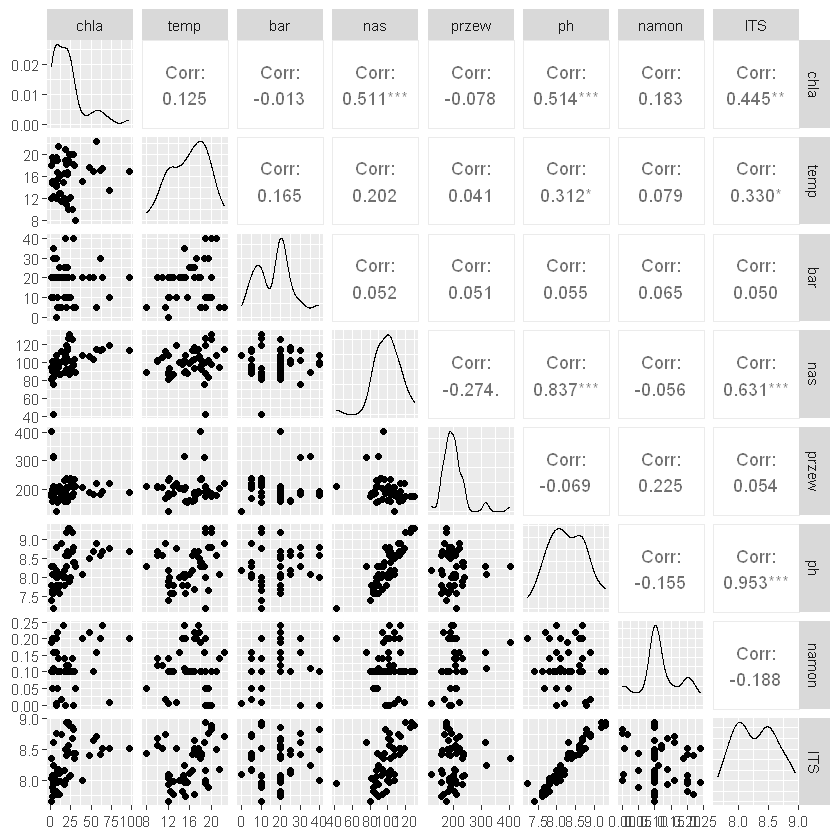

In [10]:
# wykresy zależności między zmiennymi w danych
library(GGally)
ggpairs(dane, columns = kolumny_do_analizy)

Wykresy zależności pokazują, że między `ph` a `ITS` oraz `ph` a `nas` występuje wyraźna zależność liniowa, co sugeruje silną korelację. Pozostałe zmienne wykazują słabsze lub brak istotnych zależności. Histogramy na przekątnych potwierdzają dzwonowate rozkłady analizowanych zmiennych.

## Testy zgodności z rozkładem normalnym

### Test Shapiro-Wilka

In [11]:
# test Shapiro-Wilka
shapiro_results <- dane %>% select(all_of(kolumny_do_analizy)) %>% map_df(~broom::tidy(shapiro.test(.)), .id = "zmienna")
shapiro_results <- shapiro_results %>% mutate(p.value = round(p.value, 2))
shapiro_results %>% select(zmienna, statistic, p.value)

zmienna,statistic,p.value
<chr>,<dbl>,<dbl>
chla,0.8235353,0.00
temp,0.9707482,0.24
bar,0.9099379,0.00
nas,0.9469587,0.02
przew,0.7917740,0.00
ph,0.9775584,0.44
namon,0.9103975,0.00
ITS,0.9610648,0.09


Test Shapiro-Wilka wykazał, że tylko `temp`, `ph`, i `ITS` mają rozkłady zbliżone do normalnego (p-value > 0.05). Pozostałe zmienne (`chla`, `bar`, `nas`, `przew`, `namon`) znacząco odbiegają od normalności (p-value ≤ 0.05).

### Test Kołmogorowa-Smirnowa

In [12]:
# Test Kołmogorowa-Smirnowa
ks_results <- dane %>% select(all_of(kolumny_do_analizy)) %>% map_df(~broom::tidy(ks.test(., "pnorm")), .id = "zmienna")
ks_results <- ks_results %>% mutate(p.value = round(p.value, 2))
ks_results %>% select(zmienna, statistic, p.value)

Warning message in ks.test.default(., "pnorm"):
"wartości powtórzone nie powinny być obecne w teście Kolmogorowa-Smirnowa"
Warning message in ks.test.default(., "pnorm"):
"wartości powtórzone nie powinny być obecne w teście Kolmogorowa-Smirnowa"
Warning message in ks.test.default(., "pnorm"):
"wartości powtórzone nie powinny być obecne w teście Kolmogorowa-Smirnowa"
Warning message in ks.test.default(., "pnorm"):
"wartości powtórzone nie powinny być obecne w teście Kolmogorowa-Smirnowa"
Warning message in ks.test.default(., "pnorm"):
"wartości powtórzone nie powinny być obecne w teście Kolmogorowa-Smirnowa"
Warning message in ks.test.default(., "pnorm"):
"wartości powtórzone nie powinny być obecne w teście Kolmogorowa-Smirnowa"


zmienna,statistic,p.value
<chr>,<dbl>,<dbl>
chla,0.9304524,0
temp,1.0000000,0
bar,0.9803919,0
nas,1.0000000,0
przew,1.0000000,0
ph,1.0000000,0
namon,0.5000000,0
ITS,1.0000000,0


Wyniki testu Kołmogorowa-Smirnowa pokazują, że dla wszystkich zmiennych (p-value = 0) hipoteza zerowa o normalnym rozkładzie została odrzucona. Oznacza to, że żadna z analizowanych zmiennych nie wykazuje rozkładu normalnego. 

### Badanie normalności przez skośność

In [13]:
# Badanie normalności rozkładu przez skośność
library(e1071)
skewness_results <- dane %>% select(all_of(kolumny_do_analizy)) %>% map_df(~skewness(.), .id = "zmienna")
skewness_results

Warning message:
"pakiet 'e1071' został zbudowany w wersji R 4.3.3"


chla,temp,bar,nas,przew,ph,namon,ITS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.633215,-0.2748987,0.4364116,-0.7337826,2.205302,0.1093801,0.05635184,0.1184425


Analiza skośności wskazuje, że zmienne `chla` i `przew` wykazują silną dodatnią asymetrię, co oznacza, że ich rozkłady mają dłuższe ogony po prawej stronie. Z kolei `nas` charakteryzuje się umiarkowaną ujemną skośnością, z dłuższym ogonem po lewej stronie. Pozostałe zmienne (`temp`, `ph`, `namon`, `ITS`, `bar`) mają rozkłady bliskie symetrycznym, co sugeruje brak znaczącej asymetrii. Te różnice w skośności mogą wpłynąć na wyniki analiz, zwłaszcza jeśli wymagane są dane o symetrycznym rozkładzie.

### Test Jarque-Bera

In [14]:
# Test Jarque-Bera
library(tseries)
library(broom)

jarque_bera_results <- dane %>% 
  select(all_of(kolumny_do_analizy)) %>% 
  map_df(~broom::tidy(jarque.bera.test(.)), .id = "zmienna")

jarque_bera_results <- jarque_bera_results %>% mutate(p.value = round(p.value, 2))
jarque_bera_results %>% select(zmienna, statistic, p.value)

Warning message:
"pakiet 'tseries' został zbudowany w wersji R 4.3.3"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



zmienna,statistic,p.value
<chr>,<dbl>,<dbl>
chla,41.4350405,0.00
temp,1.9045437,0.39
bar,1.8139982,0.40
nas,18.9984301,0.00
przew,158.3446852,0.00
ph,0.9794874,0.61
namon,0.4073673,0.82
ITS,2.5066229,0.29


Z testu Jarque-Bera wynika, że rozkładu normalnego nie mają jedynie: `chla`, `nas` i `przew`, ponieważ wartość p-value jest mniejsza niż 0.05. 
Wyniki testu Jarque-Bera opierają się na dwóch miarach: kurtozie i skośności.

### QQ-plot

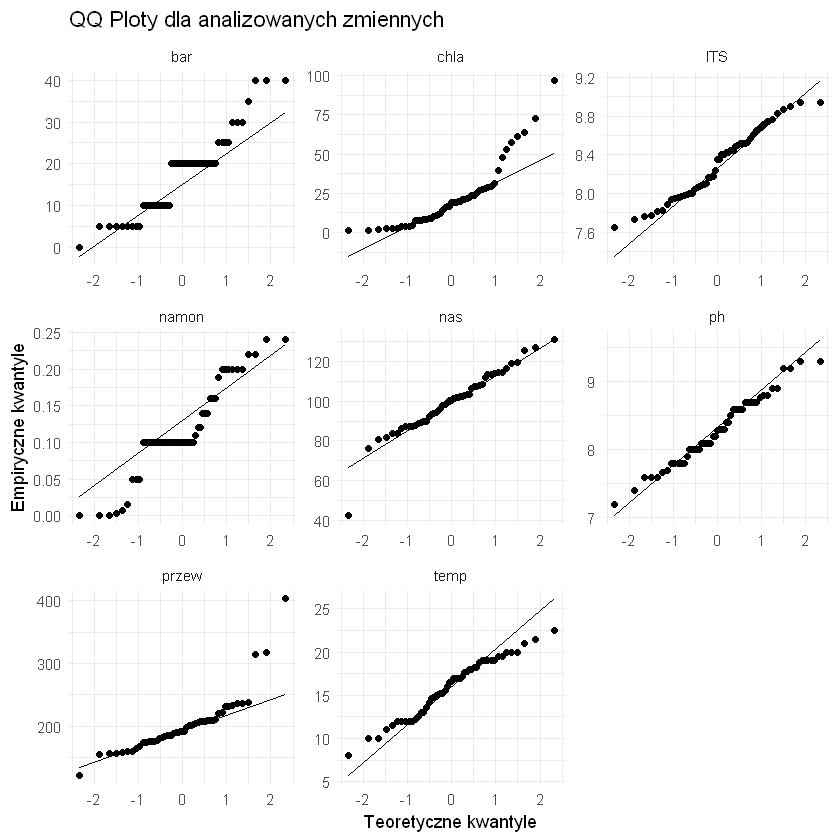

In [15]:
# QQ ploty dla analizowanych zmiennych
# Przekształcenie danych do formatu długiego
dane_long <- dane %>% 
  select(all_of(kolumny_do_analizy)) %>% 
  pivot_longer(cols = everything(), names_to = "zmienna", values_to = "wartosc")

# Tworzenie QQ plotów z facet_wrap
ggplot(dane_long, aes(sample = wartosc)) +
  stat_qq() +
  stat_qq_line() +
  facet_wrap(~ zmienna, scales = "free") +
  labs(title = "QQ Ploty dla analizowanych zmiennych",
       x = "Teoretyczne kwantyle",
       y = "Empiryczne kwantyle") +
  theme_minimal()

Na podstawie powyższych wykresów QQ-plot można stwierdzić, że zmienne **ITS**, **ph**, **temp** mają rozkład zbliżony do normalnego, ponieważ punkty znajdują się blisko linii prostej. Zmienne **bar**, **chla**, **namon**, **nas**, **przew** w tym przypadku odbiegają od linii prostej, co sugeruje, że dane mogą nie spełniać założeń o normalności rozkładu. W szczególności wartości w ogonach rozkładu znacząco odchodzą od linii, co może sugerować obecność skrajnych obserwacji.

W przypadku zmiennej **nas** większość punktów układa się blisko linii prostej, co wskazuje na zgodność z rozkładem normalnym. Jednak jeden punkt znacząco odbiega od wzorca, co sugeruje obecność potencjalnego outliera (wartości odstającej). Może to wynikać z błędu pomiarowego lub specyficznego przypadku w danych. Należy zweryfikować tę obserwację i rozważyć jej wpływ na dalsze analizy, np. poprzez porównanie wyników z i bez tego punktu.

## Testy wartości odstających

### Test Grubbsa

#### Przed odrzuconymi wartościami odstającymi

In [16]:
# test Grubbsa
library(outliers)

# Funkcja do przeprowadzenia testu Grubbsa
perform_grubbs_test <- function(data, type = 10, opposite = FALSE) {
    results <- data %>% 
        select(all_of(kolumny_do_analizy)) %>% 
        map_df(~broom::tidy(grubbs.test(.,type = type, opposite = opposite)), .id = "zmienna")
    
    results <- results %>% 
        group_by(zmienna) %>% 
        slice(1) %>% 
        mutate(p.value = round(p.value, 2))
    
    return(results %>% select(zmienna, p.value, alternative))
}

# Wyniki testu Grubbsa przed usunięciem wartości odstających
grubbs_results_before <- perform_grubbs_test(dane)
grubbs_results_before

zmienna,p.value,alternative
<chr>,<dbl>,<chr>
ITS,1.00,highest value 8.94523 is an outlier
bar,0.49,highest value 40 is an outlier
chla,0.00,highest value 97 is an outlier
namon,1.00,highest value 0.24 is an outlier
nas,0.00,lowest value 42.07 is an outlier
ph,0.70,lowest value 7.2 is an outlier
przew,0.00,highest value 403 is an outlier
temp,0.41,lowest value 8 is an outlier


Wyniki testu Grubbsa wskazują na obecność wartości odstających dla kilku zmiennych. Istotne wartości odstające (p-value ≤ 0.05) zidentyfikowano w zmiennych `chla` (97), `nas` (42.07), oraz `przew` (403). Oznacza to, że te obserwacje znacząco różnią się od pozostałych i mogą wymagać dalszej analizy lub uwzględnienia w preprocessing danych. Dla pozostałych zmiennych, mimo wskazania potencjalnych wartości odstających, test nie potwierdził ich istotności statystycznej (p-value > 0.05).

In [17]:
# Wyniki testu Grubbsa po drugiej stronie rozkładu
grubbs_results_before_opposite <- perform_grubbs_test(dane, opposite = TRUE)
grubbs_results_before_opposite

zmienna,p.value,alternative
<chr>,<dbl>,<chr>
ITS,1.00,lowest value 7.64986 is an outlier
bar,1.00,lowest value 0 is an outlier
chla,1.00,lowest value 1.1 is an outlier
namon,1.00,lowest value 0 is an outlier
nas,0.89,highest value 131.06 is an outlier
ph,1.00,highest value 9.3 is an outlier
przew,1.00,lowest value 122 is an outlier
temp,1.00,highest value 22.5 is an outlier


Wyniki testu Grubbsa dla przeciwnej strony rozkładu wskazują, że żadne z niskich wartości w analizowanych zmiennych nie zostały uznane za istotne wartości odstające (p-value > 0.05). W porównaniu do poprzedniego testu, jedyną zauważalną zmianą jest brak istotnych odstających wartości w `nas`, co sugeruje, że ekstremalnie wysokie wartości w tej zmiennej nie różnią się istotnie od reszty danych.

#### Po odrzuconych wartościach odstających

In [18]:
# Usunięcie wartości odstających

# Funkcja do usunięcia wartości największych i najmniejszych, zastępując je NA  
delate_max_and_min_values <- function(data) {
    results <- data %>% 
        mutate(across(all_of(kolumny_do_analizy), ~replace(., which.max(.), NA))) %>%
        mutate(across(all_of(kolumny_do_analizy), ~replace(., which.min(.), NA)))

    return(results)
}

# Usunięcie wartości odstających
dane_cleaned_max_min <- delate_max_and_min_values(dane)

# Wyniki testu Grubbsa po usunięciu wartości odstających
grubbs_results_after <- perform_grubbs_test(dane_cleaned_max_min)
grubbs_results_after

zmienna,p.value,alternative
<chr>,<dbl>,<chr>
ITS,1.00,highest value 8.94338 is an outlier
bar,0.27,highest value 40 is an outlier
chla,0.04,highest value 72.5 is an outlier
namon,0.87,highest value 0.24 is an outlier
nas,0.57,highest value 127.29 is an outlier
ph,0.67,highest value 9.3 is an outlier
przew,0.00,highest value 317 is an outlier
temp,1.00,lowest value 10 is an outlier


Po usunięciu skrajnych wartości test Grubbsa wskazuje mniej istotnych wartości odstających. `chla` (72.5, p = 0.04) i `przew` (317, p = 0.00) wciąż mają istotne odstępstwa, ale ich skrajności zostały złagodzone. Dla innych zmiennych wartości odstające przestały być istotne (p > 0.05).

In [19]:
# Wyniki testu Grubbsa po drugiej stronie rozkładu
grubbs_results_after_opposite <- perform_grubbs_test(dane_cleaned_max_min, opposite = TRUE)
grubbs_results_after_opposite

zmienna,p.value,alternative
<chr>,<dbl>,<chr>
ITS,1,lowest value 7.73416 is an outlier
bar,1,lowest value 5 is an outlier
chla,1,lowest value 1.25 is an outlier
namon,1,lowest value 0 is an outlier
nas,1,lowest value 75.9 is an outlier
ph,1,lowest value 7.4 is an outlier
przew,1,lowest value 155 is an outlier
temp,1,highest value 21.5 is an outlier


Po usunięciu skrajnych wartości test Grubbsa dla przeciwnej strony rozkładu nie wykazał żadnych istotnych wartości odstających (p-value = 1 dla wszystkich zmiennych). Oznacza to, że po oczyszczeniu danych niskie wartości przestały być uznawane za odstające.

### Test Dixona

#### Przed odrzuconymi wartościami odstającymi

In [20]:
# Funkcja do przeprowadzenia testu Dixona

perform_dixon_test <- function(data, type = 0, opposite = FALSE) {
    results <- data %>% 
        select(all_of(kolumny_do_analizy)) %>% 
        map_df(~broom::tidy(dixon.test(.,type = type, opposite = opposite)), .id = "zmienna")
    
    results <- results %>% 
        group_by(zmienna) %>% 
        slice(1) %>% 
        mutate(p.value = round(p.value, 2))
    
    return(results %>% select(zmienna, p.value, alternative))
}


dane_30_wierszy <- dane %>% slice(1:30)
# Wyniki testu Dixona przed usunięciem wartości odstających
dixon_results_before <- perform_dixon_test(dane_30_wierszy)
dixon_results_before

zmienna,p.value,alternative
<chr>,<dbl>,<chr>
ITS,0.47,highest value 8.82574 is an outlier
bar,0.00,highest value 40 is an outlier
chla,0.89,highest value 72.5 is an outlier
namon,0.30,highest value 0.24 is an outlier
nas,0.62,highest value 118.8 is an outlier
ph,0.72,lowest value 7.4 is an outlier
przew,0.23,lowest value 122 is an outlier
temp,0.81,lowest value 8 is an outlier


Wyniki testu Dixona przeprowadzonego na pierwszych 30 obserwacjach wskazują, że jedynie w przypadku zmiennej `bar` (p = 0.00) najwyższa wartość (40) została uznana za istotną statystycznie wartość odstającą. Dla pozostałych zmiennych, pomimo wskazania potencjalnych wartości odstających, p-value jest większe niż 0.05, co oznacza brak istotności statystycznej. Oznacza to, że dla większości zmiennych test Dixona nie potwierdził obecności istotnych odstępstw.

In [21]:
# Wyniki testu Dixona po drugiej stronie rozkładu
dixon_results_before_opposite <- perform_dixon_test(dane_30_wierszy, opposite = TRUE)
dixon_results_before_opposite

zmienna,p.value,alternative
<chr>,<dbl>,<chr>
ITS,0.56,lowest value 7.64986 is an outlier
bar,0.59,lowest value 0 is an outlier
chla,0.03,lowest value 1.1 is an outlier
namon,0.00,lowest value 0 is an outlier
nas,0.30,lowest value 80.78 is an outlier
ph,0.26,highest value 8.9 is an outlier
przew,0.32,highest value 238 is an outlier
temp,0.56,highest value 22.5 is an outlier


Po przeciwnej stronie rozkładu test Dixona wykazał istotne wartości odstające dla zmiennych `chla` (1.1, p = 0.03) i `namon` (0, p = 0.00). Dla pozostałych zmiennych wartości odstające nie są statystycznie istotne (p > 0.05).

#### Po odrzuconych wartościach odstających

In [22]:
# Usunięcie wartości odstających
dane_30_cleaned_max_min <- delate_max_and_min_values(dane_30_wierszy)

# Wyniki testu Dixona po usunięciu wartości odstających
dixon_results_after <- perform_dixon_test(dane_30_cleaned_max_min)
dixon_results_after

zmienna,p.value,alternative
<chr>,<dbl>,<chr>
ITS,0.31,highest value 8.76815 is an outlier
bar,0.41,highest value 40 is an outlier
chla,0.48,highest value 64 is an outlier
namon,0.29,highest value 0.24 is an outlier
nas,0.10,highest value 114.45 is an outlier
ph,0.04,highest value 8.8 is an outlier
przew,0.63,lowest value 155 is an outlier
temp,0.69,highest value 21.5 is an outlier


Po usunięciu skrajnych wartości test Dixona wykazał, że oprócz `ph` (8.8, p = 0.04), żadna z wartości odstających nie jest statystycznie istotna (p > 0.05).

In [23]:
# Wyniki testu Dixona po drugiej stronie rozkładu
dixon_results_after_opposite <- perform_dixon_test(dane_30_cleaned_max_min, opposite = TRUE)
dixon_results_after_opposite

zmienna,p.value,alternative
<chr>,<dbl>,<chr>
ITS,0.28,lowest value 7.73416 is an outlier
bar,0.00,lowest value 5 is an outlier
chla,0.00,lowest value 2.3 is an outlier
namon,0.01,lowest value 0 is an outlier
nas,0.58,lowest value 83.5 is an outlier
ph,0.16,lowest value 7.6 is an outlier
przew,0.63,highest value 231 is an outlier
temp,0.39,lowest value 10 is an outlier


Po usunięciu skrajnych wartości test Dixona po drugiej stronie rozkładu wykazał istotne wartości odstające dla zmiennych `bar` (5, p = 0.00), `chla` (2.3, p = 0.00), oraz `namon` (0, p = 0.01). Dla pozostałych zmiennych p-value jest większe niż 0.05, co oznacza brak istotnych wartości odstających po oczyszczeniu danych.

### Metoda IQR (Interquartile Range)

Wartości odstające są identyfikowane na podstawie odległości między kwartylami Q1 i Q3. Wartości odstające są identyfikowane jako wartości, które są mniejsze niż Q1 - 1,5 * IQR lub większe niż Q3 + 1,5 * IQR, gdzie IQR = Q3 - Q1.

In [24]:
detect_outliers_iqr <- function(data, variable) {
  Q1 <- quantile(data[[variable]], 0.25)
  Q3 <- quantile(data[[variable]], 0.75)
  IQR <- Q3 - Q1
  lower_bound <- Q1 - 1.5 * IQR
  upper_bound <- Q3 + 1.5 * IQR
  data %>% filter(data[[variable]] < lower_bound | data[[variable]] > upper_bound)
}
detect_outliers_iqr_all <- function(data, variables) {
    outliers_df <- data %>% mutate(across(all_of(variables), ~ifelse(. < quantile(., 0.25) - 1.5 * IQR(.) | . > quantile(., 0.75) + 1.5 * IQR(.), 1, 0), .names = "outlier_{col}"))
    return(outliers_df)
}

dane_with_outliers <- detect_outliers_iqr_all(dane, kolumny_do_analizy)
head(dane_with_outliers)



chla,temp,bar,nas,przew,ph,namon,ITS,outlier_chla,outlier_temp,outlier_bar,outlier_nas,outlier_przew,outlier_ph,outlier_namon,outlier_ITS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.1,12.0,10,80.78,176,7.40,0.100,7.64986,0,0,0,0,0,0,0,0
2.5,15.2,20,89.68,157,7.60,0.100,7.73416,0,0,0,0,0,0,0,0
8.6,19.0,5,87.50,207,8.00,0.050,8.16250,0,0,0,0,0,0,0,0
2.3,19.5,10,83.50,189,7.67,0.050,7.88450,0,0,0,0,0,0,0,0
7.5,12.0,0,108.30,122,8.20,0.004,8.09210,0,0,0,0,1,0,1,0
10.3,21.5,5,94.16,202,8.10,0.140,8.17592,0,0,0,0,0,0,0,0


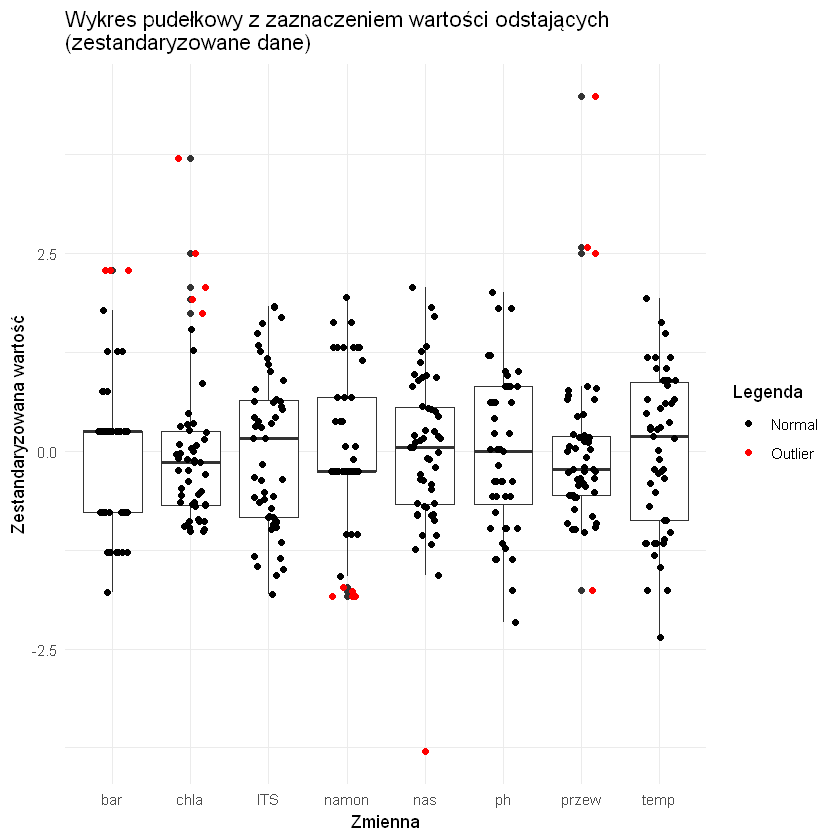

In [25]:
# Standaryzacja danych
dane_standardized <- dane %>% 
    mutate(across(all_of(kolumny_do_analizy), ~scale(.) %>% as.vector()))

# Dodanie informacji o outlierach do zestandaryzowanych danych
dane_standardized_with_outliers <- detect_outliers_iqr_all(dane_standardized, kolumny_do_analizy)

# Przekształcenie danych do formatu długiego z informacją o outlierach
dane_long_outliers_standardized <- dane_standardized_with_outliers %>% 
    pivot_longer(cols = all_of(kolumny_do_analizy), names_to = "zmienna", values_to = "wartosc") %>% 
    pivot_longer(cols = starts_with("outlier_"), names_to = "outlier_zmienna", values_to = "outlier") %>% 
    filter(str_replace(outlier_zmienna, "outlier_", "") == zmienna)

# Tworzenie wykresu pudełkowego z zaznaczeniem wartości odstających
ggplot(dane_long_outliers_standardized, aes(x = zmienna, y = wartosc)) +
    geom_boxplot() +
    geom_jitter(aes(color = factor(outlier)), width = 0.2, height = 0) +
    scale_color_manual(values = c("0" = "black", "1" = "red"), labels = c("0" = "Normal", "1" = "Outlier")) +
    labs(title = "Wykres pudełkowy z zaznaczeniem wartości odstających \n(zestandaryzowane dane)",
             x = "Zmienna",
             y = "Zestandaryzowana wartość",
             color = "Legenda") +
    theme_minimal()

Wykres pudełkowy dobrze obrazuje działanie metody IQR, ponieważ poziome linie, które ograniczają skrzynię, wskazują przedziały kwantyli powiększonych o 1,5 * IQR. Jeśli wartość znajduje się poza tymi granicami, jest uznawana za wartość odstającą. W tym przypadku punkty znajdujące się poza granicami skrzyni zostały dodatkowo wyróżnione kolorem czerwonym.

Można zaobserwować, że wartości odstające są identyfikowane w zmiennych `bar`, `chla`, `namon`, `nas` i `przew`. Zmienne te były wskazywane już wcześniej w testach statystycznych jako potencjalne wartości odstające. 

## Korelacje



### Korelacja Pearsona

**Korelacja Pearsona** to miara statystyczna określająca siłę i kierunek **liniowej** zależności między dwiema zmiennymi. Wartość współczynnika mieści się w przedziale [-1, 1]. Im bliżej 1 lub -1, tym zależność jest silniejsza.

Korelacja Pearsona najlepiej opisuje zależności liniowe. Jeśli związek między zmiennymi ma bardziej skomplikowany charakter (np. paraboliczny, wykładniczy), współczynnik Pearsona może nie odzwierciedlać rzeczywistej zależności.

Warning message:
"pakiet 'corrplot' został zbudowany w wersji R 4.3.3"
corrplot 0.92 loaded



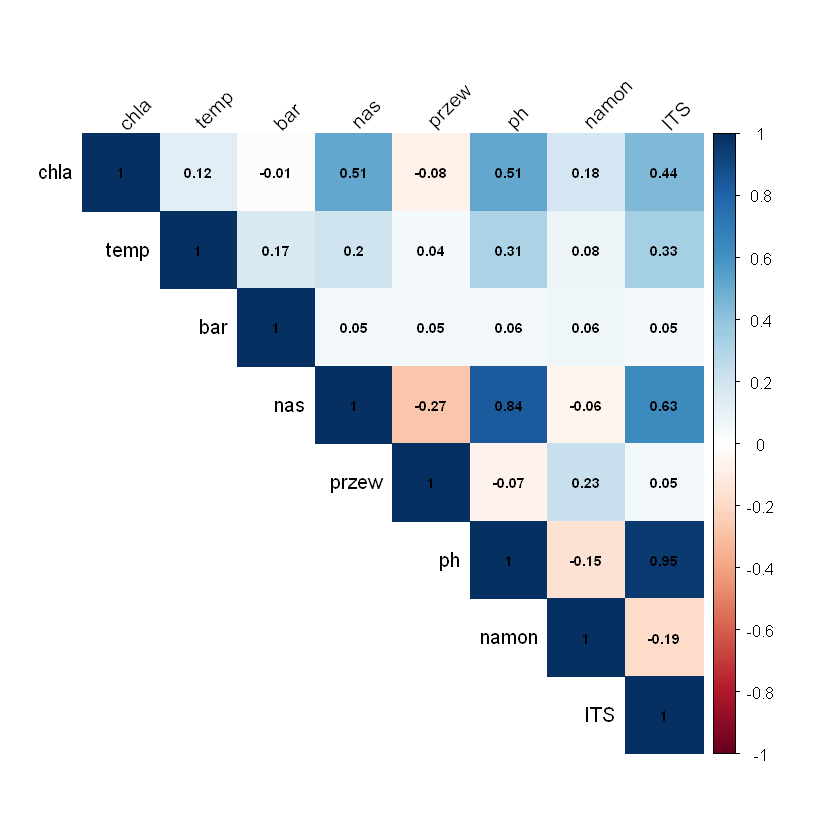

In [26]:
# Korelacja Pearsona
library(corrplot)

correlation_matrix <- cor(dane_standardized %>% select(all_of(kolumny_do_analizy)), method = "pearson")
corrplot(
    correlation_matrix,
    method = "color", 
    type = "upper", 
    tl.col = "black", 
    tl.srt = 45, 
    addCoef.col = "black", 
    number.cex = 0.7
)


Na podstawie analizy korelacji Pearsona można stwierdzić, że zmienne:

- `ITS` i `ph` są silnie skorelowane (0.95),
- `nas` i `ph` są silnie skorelowane (0.84),
- `ITS` i `nas` są umiarkowanie skorelowane (0.63),

pozostałe zmienne są słabo skorelowane lub nie wykazują istotnych zależności.

### Korelacja Spearmana

**Korelacja Spearmana** to miara statystyczna, która służy do oceny siły i kierunku monotonicznej zależności między dwiema zmiennymi. Innymi słowy, pozwala nam sprawdzić, czy wraz ze wzrostem jednej zmiennej, druga również rośnie (zależność dodatnia) lub maleje (zależność ujemna).

W przeciwieństwie do korelacji Pearsona, korelacja Spearmana nie musi mieć zależności liniowej, natomiast wymagana jest monotoniczność. Dlatego jest bardziej uniwersalna i może wykryć zależności, które nie zostałyby ujawnione przez korelację Pearsona.

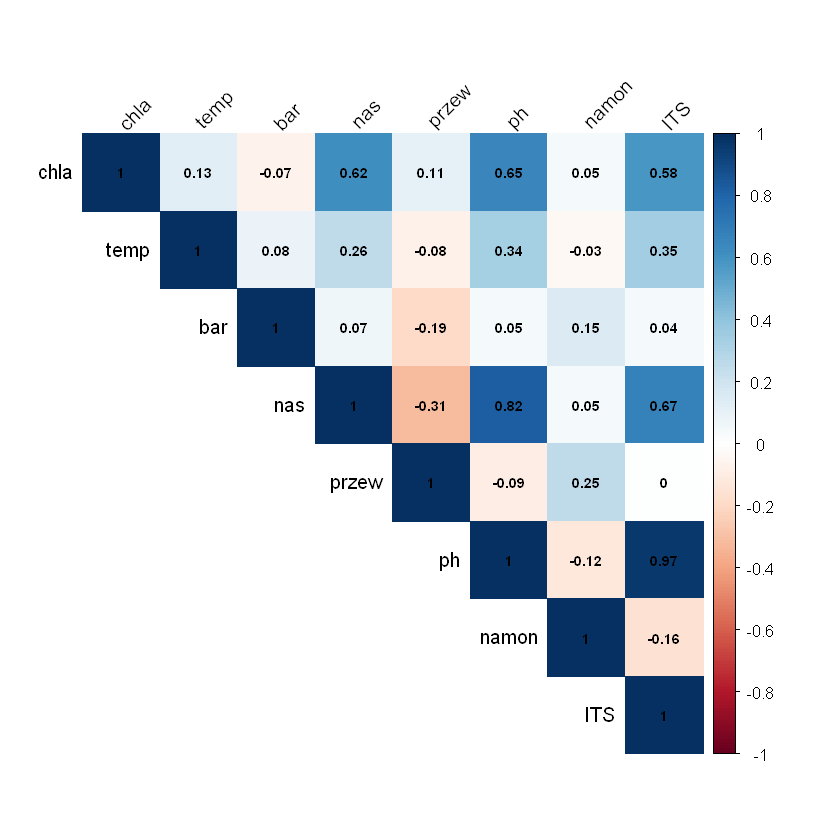

In [27]:
# Korelacja Spearmana
correlation_matrix_spearman <- cor(dane_standardized %>% select(all_of(kolumny_do_analizy)), method = "spearman")
corrplot(
    correlation_matrix_spearman,
    method = "color", 
    type = "upper", 
    tl.col = "black", 
    tl.srt = 45, 
    addCoef.col = "black", 
    number.cex = 0.7
)

Zależności, które według korelacji Pearsona były sinie skorelowane, według korelacji Spearmana są również silnie skorelowane. Dodatkowo, w porównaniu do korelacji Pearsona, pewne zależności są bardziej wyraźne i sa to:

- `chla` i `nas` (0.62)
- `chla` i `ph` (0.65)

## Autokorelacja (ACF)

**Wykresy autokorelacji** pozwalają ocenić, jak bardzo wartości w szeregu czasowym są powiązane z jego przeszłymi wartościami.

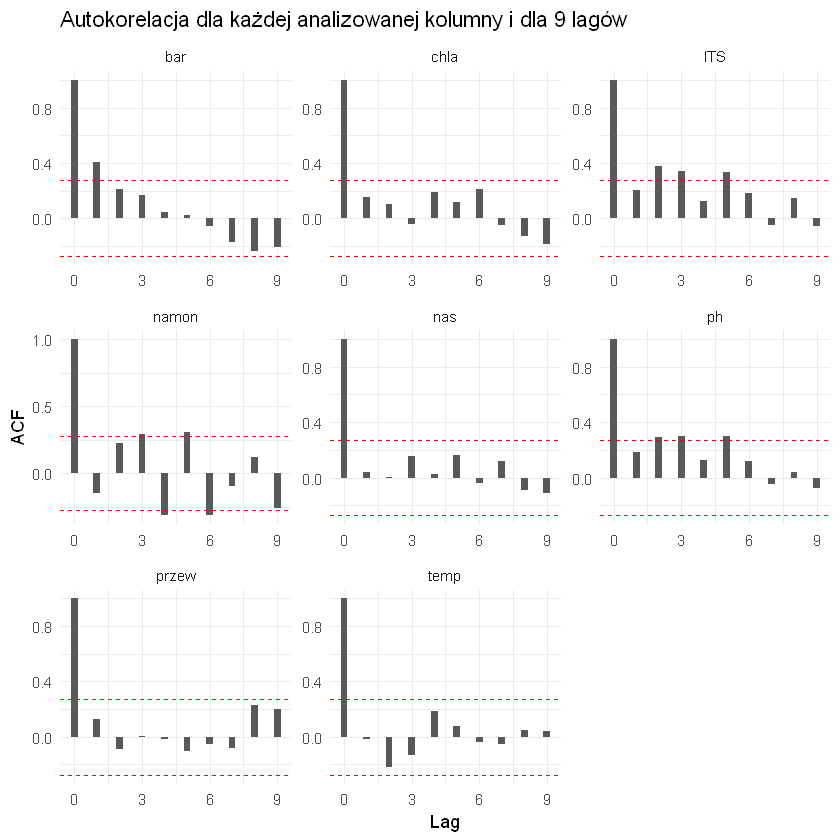

In [28]:

# Autokorelacja dla każdej analizowanej kolumny i dla 9 lagów za pomocą ggplot2
acf_data <- map_df(kolumny_do_analizy, function(kolumna) {
    acf_values <- acf(dane_standardized[[kolumna]], lag.max = 9, plot = FALSE)
    tibble(
        lag = acf_values$lag,
        acf = acf_values$acf,
        zmienna = kolumna
    )
})

significance_level <- 1.96 / sqrt(nrow(dane_standardized))

ggplot(acf_data, aes(x = lag, y = acf, group = zmienna)) +
    geom_bar(stat = "identity", width = 0.3) +
    geom_hline(yintercept = c(-significance_level, significance_level), linetype = "dashed", color = "red") +
    facet_wrap(~ zmienna, scales = "free") +
    scale_x_continuous(breaks = seq(0, 9, by = 3)) +
    labs(title = "Autokorelacja dla każdej analizowanej kolumny i dla 9 lagów",
         x = "Lag",
         y = "ACF") +
    theme_minimal()


Na wykresach autokorelacji można zauważyć, że nie ma wyraźnych wzorców ani regularności w zależnościach między wartościami. Wszystkie istotne wartości autokorelacji mieszczą się w przedziale ufności, bądź są bliskie granicy. Oznacza to, że nie ma silnych zależności między wartościami w szeregu czasowym, co sugeruje brak autokorelacji.

## Regresja liniowa dla ITS i Chlorofilu  

### Histogramy z wyróżnionymi danymi testowymi i treningowymi za pomocą kolorów

In [29]:
#| code-fold: false
# podział danych na zbiór treningowy i testowy
set.seed(123)
indeksy <- sample(1:nrow(dane), 0.7 * nrow(dane))
dane_treningowe <- dane[indeksy, ]
dane_testowe <- dane[-indeksy, ]

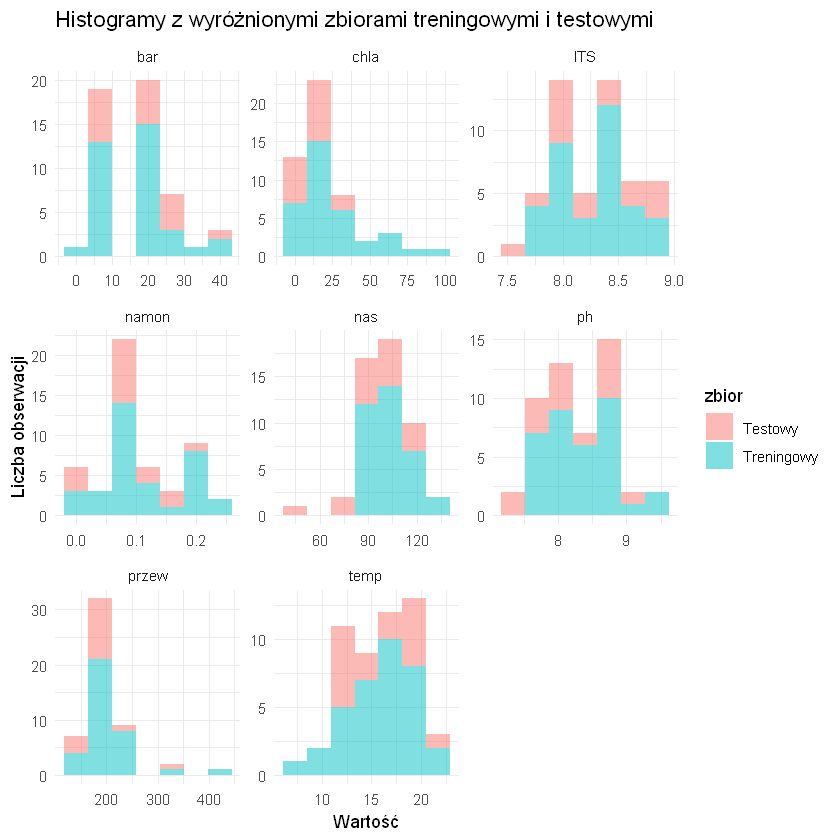

In [30]:
# histogramy z wyróżnionymi zbiorami treningowymi i testowymi za pomocą kolorów
hist_data <- dane %>% mutate(zbior = ifelse(row_number() %in% indeksy, "Treningowy", "Testowy")) %>% 
    gather(key = "zmienna", value = "wartosc", all_of(kolumny_do_analizy))

ggplot(hist_data, aes(x = wartosc, fill = zbior)) +
    geom_histogram(bins = 7, alpha = 0.5) +
    facet_wrap(~ zmienna, scales = "free") +
    labs(title = "Histogramy z wyróżnionymi zbiorami treningowymi i testowymi",
         x = "Wartość",
         y = "Liczba obserwacji") +
    theme_minimal()

Na histogramach można zauważyć, że dane testowe i treningowe są w miarę równomiernie rozłożone wśród poszczególnych zmiennych. 

### Model regresji liniowej dla ITS

Poniżej przedstawiono kod do stworzenia modelu regresji liniowej dla zmiennej `ITS` w R. 

In [31]:
#| code-fold: false
# utworzenie modelu regresji liniowej dla ITS
model_ITS <- lm(ITS ~ ., select(dane_treningowe, all_of(kolumny_do_analizy)))

#### Istotność współczynników

In [32]:
#| code-fold: false
# istotność współczynników
summary(model_ITS)$coefficients

Warning message in summary.lm(model_ITS):
"idealne dopasowanie: podsumowanie może nie być wiarygodne"


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),1.300000e+00,2.437632e-15,5.333044e+14,0.0000000
chla,7.766239e-20,5.038904e-18,1.541256e-02,0.9878164
temp,3.457603e-17,2.992591e-17,1.155388e+00,0.2580544
bar,-1.640750e-17,9.703670e-18,-1.690855e+00,0.1023783
nas,-1.300000e-02,1.841626e-17,-7.058978e+14,0.0000000
przew,2.098917e-18,2.268764e-18,9.251370e-01,0.3630900
ph,1.000000e+00,4.769034e-16,2.096861e+15,0.0000000
namon,1.417460e-15,1.559877e-15,9.086996e-01,0.3715489


Wyniki regresji liniowej dla zmiennej zależnej `ITS` wskazują na następujące zależności między zmiennymi niezależnymi a zmienną zależną:

1. **Zmienne istotne statystycznie**:
   - `nas` (p-value ≈ 0.00): Jest silnie istotnym predyktorem i ma ujemny wpływ na zmienną `ITS`.
   - `ph` (p-value ≈ 0.00): Jest również bardzo istotnym predyktorem, z dodatnim wpływem na `ITS`.

2. **Zmienne nieistotne statystycznie**:
   - `chla`, `temp`, `bar`, `przew`, i `namon` mają wysokie wartości p-value (> 0.05), co sugeruje, że nie są istotnymi predyktorami w modelu dla `ITS`.

3. **Intercept (wyraz wolny)**: Intercept wynosi około 1.3 i jest istotny statystycznie (p-value ≈ 0.00).

Podsumowując, model pokazuje, że `ph` i `nas` mają największy wpływ na zmienną `ITS`, podczas gdy pozostałe zmienne nie mają istotnego znaczenia statystycznego w tym modelu.

#### Normalność reszt

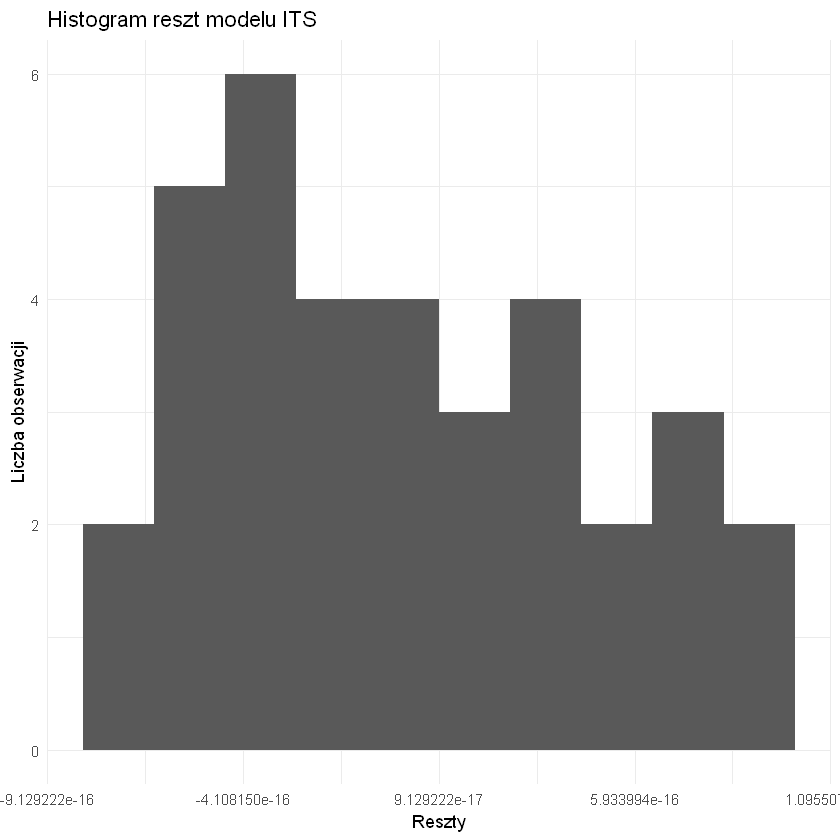

In [33]:
# dane z resztami i wartościami dopasowanymi
residuals <- dane_treningowe %>% 
    mutate(reszty = residuals(model_ITS)) %>%
    mutate(wpasowanie = fitted(model_ITS))

# histogram reszt
ggplot(residuals, aes(x = reszty)) +
    geom_histogram(bins = 10) +
    labs(title = "Histogram reszt modelu ITS",
         x = "Reszty",
         y = "Liczba obserwacji") +
    theme_minimal()

Ciężko jest stwierdzić na podstawie wykresu rozkładu reszt czy spełnione są założenia o normalności. Wartości reszt wydają się być rozłożone w sposób losowy, jednak nie można jednoznacznie stwierdzić, czy spełnione są założenia o normalności.

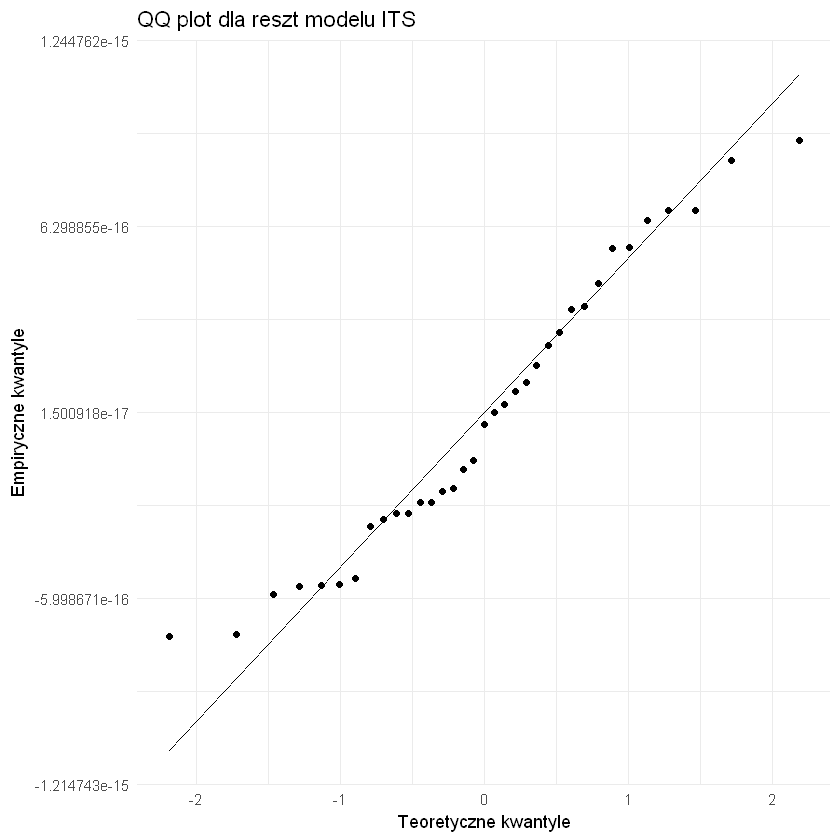

In [34]:
# wykres QQ dla reszt
residuals %>%
    ggplot(aes(sample = reszty)) +
    stat_qq() +
    stat_qq_line() +
    labs(title = "QQ plot dla reszt modelu ITS",
         x = "Teoretyczne kwantyle",
         y = "Empiryczne kwantyle") +
    theme_minimal()


QQ plot dla reszt modelu ITS wskazuje, że reszty są bliskie rozkładowi normalnemu, ponieważ większość punktów układa się wzdłuż linii prostej. Niewielkie odchylenia od tej linii można zaobserwować na krańcach rozkładu, co może sugerować drobne odstępstwa od normalności dla wartości skrajnych. Ogólnie jednak rozkład reszt wydaje się być zgodny z założeniami modelu.

In [35]:
#| code-fold: false
# test Jarque-Bera dla reszt
jarque_bera_test <- jarque.bera.test(residuals$reszty)
jarque_bera_test


	Jarque Bera Test

data:  residuals$reszty
X-squared = 2.0034, df = 2, p-value = 0.3673


Na podstawie wyniku testu Jarque Bera można stwierdzić: 

- Ponieważ wartość p (p-value = 0.3673) jest większa niż typowy poziom istotności (np. 0.05), nie mamy podstaw do odrzucenia hipotezy zerowej.
- Hipoteza zerowa (H₀): Reszty mają rozkład normalny.
- W tym przypadku można przyjąć, że reszty są zgodne z rozkładem normalnym.

#### Homoskedastyczność

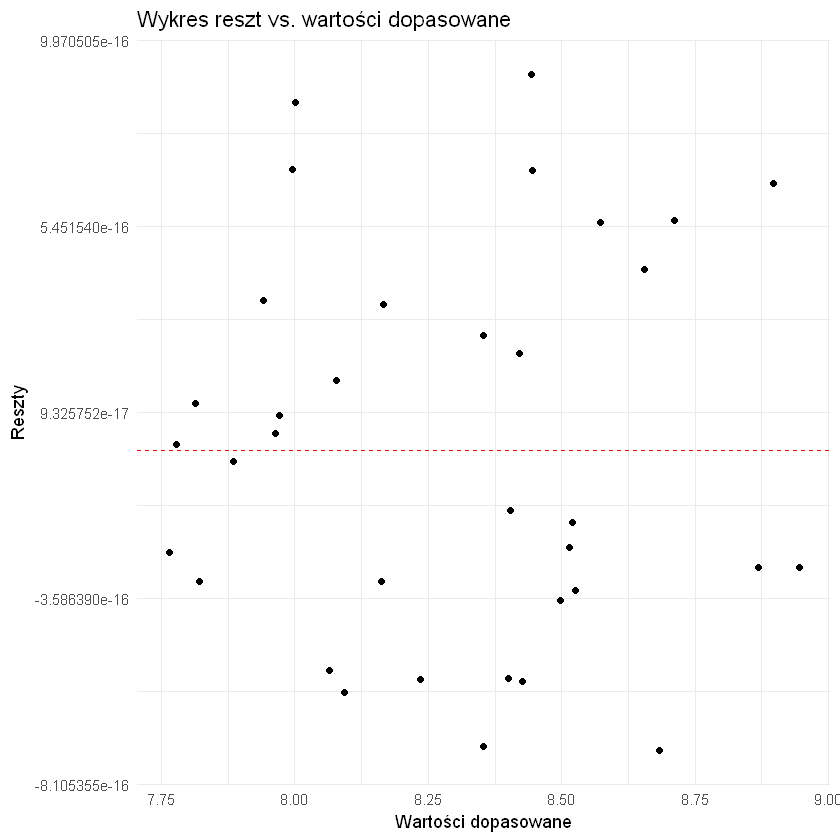

In [36]:
# wykres reszt vs. wartości dopasowane (homoskedastyczność)
residuals %>%
    ggplot(aes(x = wpasowanie, y = reszty)) +
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(title = "Wykres reszt vs. wartości dopasowane",
         x = "Wartości dopasowane",
         y = "Reszty") +
    theme_minimal()

Na wykresie można zaobserwować, że reszty są losowo rozrzucone wokół osi y = 0, co sugeruje, że wariancja reszt jest stała, więc założenie o homoskedastyczności jest spełnione.

#### Autokorelacja reszt

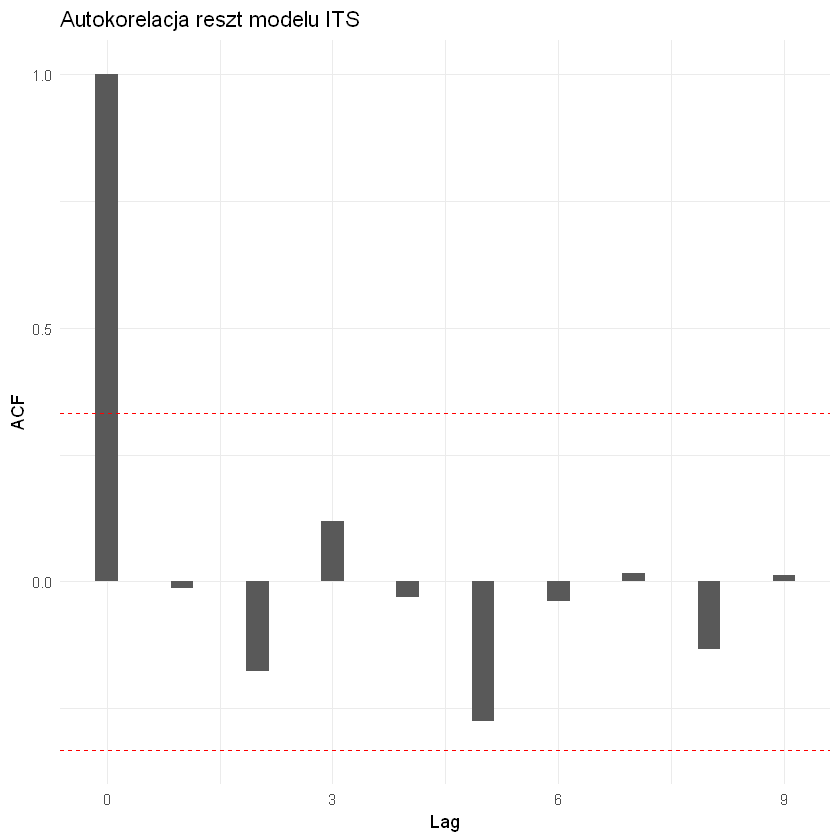

In [37]:
# autokorelacja reszt
plot_acf_residuals <- function(residuals_vector, title, lag = 9) {
     acf_res <- acf(residuals_vector, lag.max = lag, plot = FALSE)
     
     afc_res_tibble <- tibble(
          lag = acf_res$lag,
          acf = acf_res$acf
     )
     
     significance_level <- 1.96 / sqrt(length(residuals_vector))
     
     ggplot(afc_res_tibble, aes(x = lag, y = acf)) +
          geom_bar(stat = "identity", width = 0.3) +
          geom_hline(yintercept = c(-significance_level, significance_level), linetype = "dashed", color = "red") +
          scale_x_continuous(breaks = seq(0, 9, by = 3)) +
          labs(title = title,
                x = "Lag",
                y = "ACF") +
          theme_minimal()
}

plot_acf_residuals(residuals$reszty, "Autokorelacja reszt modelu ITS")

Na wykresie autokorelacji reszt można zauważyć, że wszystkie wartości autokorelacji mieszczą się w przedziale ufności, co sugeruje brak autokorelacji. Oznacza to, że reszty nie są ze sobą skorelowane i nie występuje zależność między nimi.

#### Wpływ wartości odstających

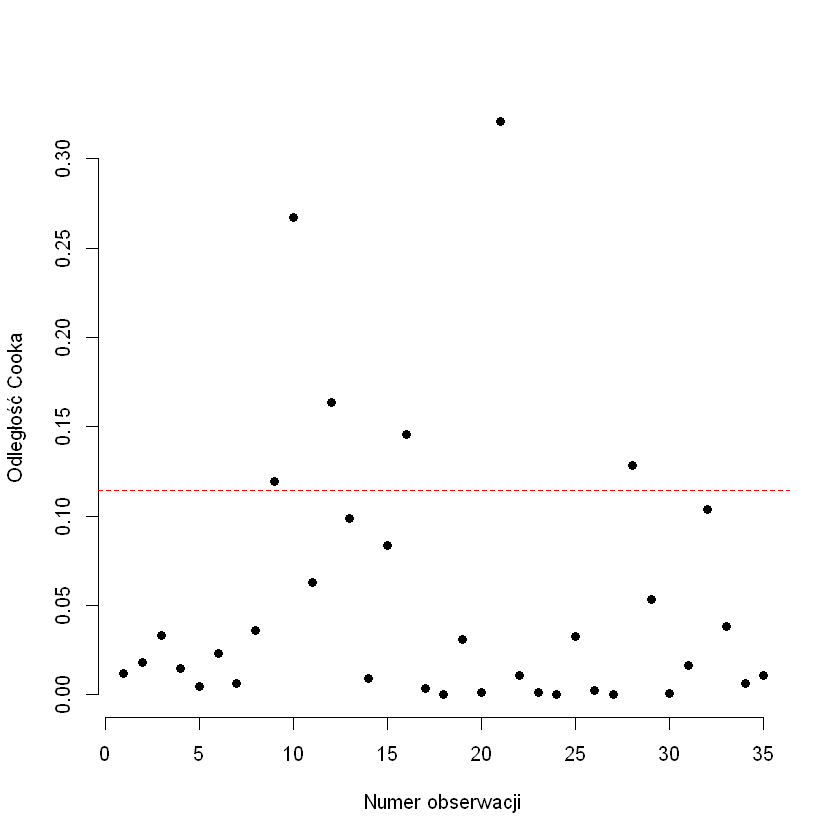

In [38]:
# Obliczanie odległości Cooka
cooks_distance <- cooks.distance(model_ITS)

# Wykres odległości Cooka
plot(cooks_distance, pch = 19, frame = FALSE, xlab = "Numer obserwacji", ylab = "Odległość Cooka")
abline(h = 4 / nrow(dane_treningowe), col = "red", lty = 2)

Na wykresie możemy zauważyć, że raptem 6 obserwacji wykracza poza zakres wartości reszt, z czego 2 wartości są znacząco odstające. 
Wartości te mogą wpływać na jakość modelu.

#### Zdolność predykcyjna modelu

Warning message:
"pakiet 'hydroGOF' został zbudowany w wersji R 4.3.3"


Ładowanie wymaganego pakietu: zoo

Warning message:
"pakiet 'zoo' został zbudowany w wersji R 4.3.3"

Dołączanie pakietu: 'zoo'


Następujące obiekty zostały zakryte z 'package:base':

    as.Date, as.Date.numeric




RMSE,MAE,MSE,R2,Korelacja.Pearsona,Korelacja.Spearmana,Korelacja.Kendall
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.404333e-15,1.221245e-15,1.972152e-30,1,1,1,1


[ Note: You did not provide dates, so only a numeric index will be used in the time axis ]



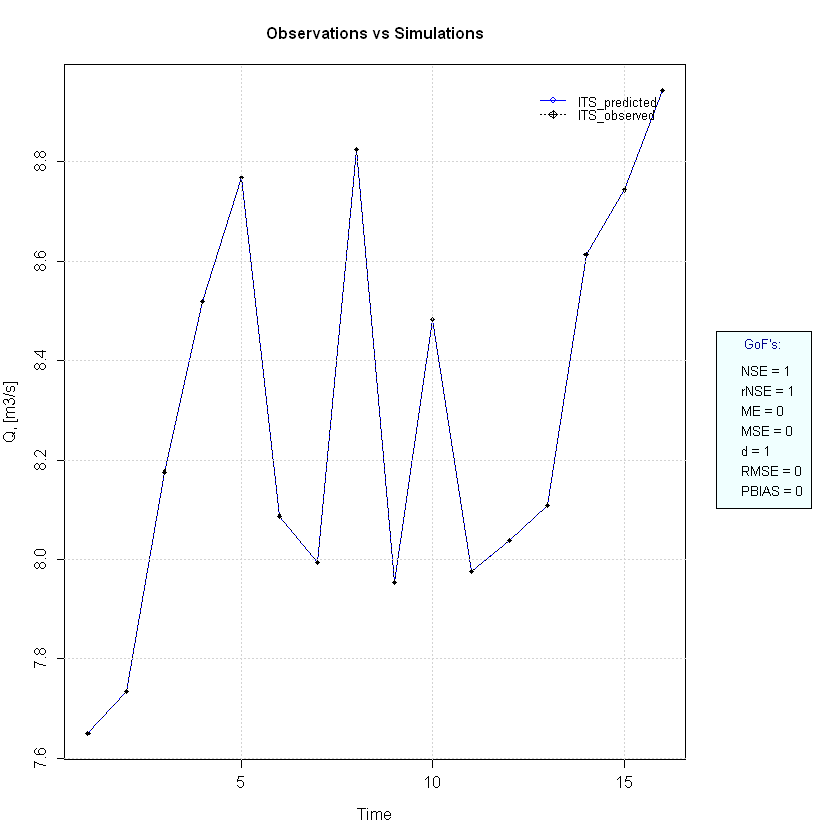

In [39]:
library(hydroGOF)

# porównanie modelu ITS z danymi testowymi
ITS_predicted <- predict(model_ITS, dane_testowe)
ITS_observed <- dane_testowe$ITS

# tabela z wynikami parametrów modelu
model_ITS_results <- data.frame(
    RMSE = rmse(ITS_predicted, ITS_observed),
    MAE = mae(ITS_predicted, ITS_observed),
    MSE = mse(ITS_predicted, ITS_observed),
    R2 = R2(ITS_predicted, ITS_observed),
    "Korelacja Pearsona" = cor(ITS_predicted, ITS_observed),
    "Korelacja Spearmana" = cor(ITS_predicted, ITS_observed, method = "spearman"),
    "Korelacja Kendall" = cor(ITS_predicted, ITS_observed, method = "kendall")
)

model_ITS_results <- tibble(model_ITS_results)
model_ITS_results

# hydroGOF
ggof(ITS_predicted, ITS_observed,
    gofs = c("NSE", "rNSE", "ME", "MSE",  "d", "RMSE", "PBIAS"),
    FUN = mean)


Wyniki oceny zdolności predykcyjnej modelu regresji liniowej dla zmiennej ITS wskazują na doskonałe dopasowanie do danych testowych:

- RMSE (Root Mean Square Error): Bardzo niska wartość (~1.4 × 10⁻¹⁵) świadczy o niemal zerowych błędach predykcji w odniesieniu do danych obserwowanych.
- MAE (Mean Absolute Error): Niska wartość (~1.2 × 10⁻¹⁵) wskazuje na niewielkie średnie różnice między wartościami przewidywanymi a obserwowanymi.
- MSE (Mean Squared Error): Również bliskie zeru (~1.97 × 10⁻³⁰), co potwierdza minimalny błąd kwadratowy.
- R²: Wartość równoważna 1 oznacza, że model w pełni wyjaśnia zmienność zmiennej ITS.
- Korelacje (Pearsona, Spearmana, Kendalla): Wszystkie korelacje mają wartość równą 1, co wskazuje na idealną zgodność między przewidywanymi a obserwowanymi wartościami.

#### Wnioski dotyczące modelu regresji liniowej dla ITS

Doskonały oceny parametrów predykcyjnych oraz idealne wyniki testów na resztach regresji liniowej dla zmiennej ITS nie mogą dziwić, biorąc pod uwagę fakt że `ITS` zostało skonstruowane jako liniowa kombinacja zmiennych `ph` i `nas`. W związku z tym, oczekiwane jest doskonałe dopasowanie modelu do danych oraz brak istotnych odchyleń w resztach.

### Model regresji liniowej dla Chlorofilu

Poniżej przedstawiono kod do stworzenia modelu regresji liniowej dla zmiennej `chla` w R.

In [40]:
#| code-fold: false
# utworzenie modelu regresji liniowej dla Chlorofilu
chla_model <- lm(chla ~ ., select(dane_treningowe, all_of(kolumny_do_analizy)))

#### Istotność współczynników

In [41]:
#| code-fold: false
# istotność współczynników
summary(chla_model)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-179.22574621,84.91679415,-2.1106042,0.04386744
temp,-0.60146391,1.11658969,-0.5386615,0.59437750
bar,-0.08502665,0.36357764,-0.2338611,0.81679431
nas,0.11615793,0.69034620,0.1682604,0.86758795
przew,-0.04457973,0.08467104,-0.5265050,0.60268365
ph,24.46748990,17.27806070,1.4161016,0.16777469
namon,81.01203635,56.46384424,1.4347595,0.16243172


Model nie identyfikuje istotnych zależności między chlorofilem a uwzględnionymi zmiennymi. Może to sugerować, że dane są niewystarczające do wykrycia takich relacji, zmienne są nieoptymalnie dobrane, lub wpływ na chlorofil pochodzi od innych, nieanalizowanych czynników.

#### Normalność reszt

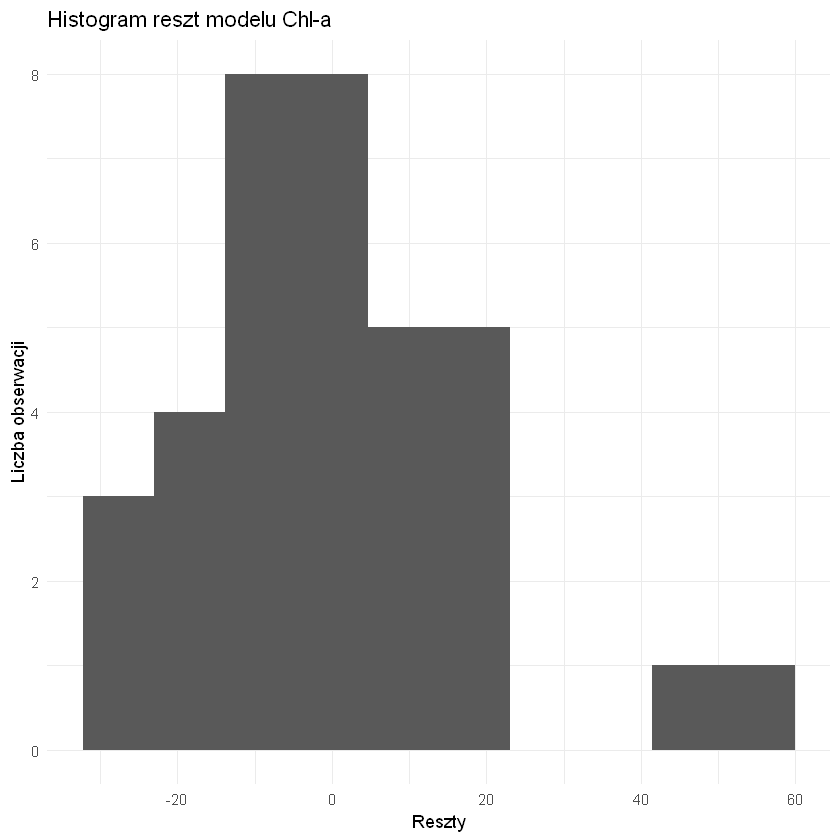

In [42]:
# dane z resztami i wartościami dopasowanymi
residuals_chla <- dane_treningowe %>% 
    mutate(reszty = residuals(chla_model)) %>%
    mutate(wpasowanie = fitted(chla_model))

# histogram reszt
ggplot(residuals_chla, aes(x = reszty)) +
    geom_histogram(bins = 10) +
    labs(title = "Histogram reszt modelu Chl-a",
         x = "Reszty",
         y = "Liczba obserwacji") +
    theme_minimal()

Na podstawie wykresu rozkładu reszt można stwierdzić, że rozkład jest normalny, jednak należy to potwierdzić za pomocą testów statystycznych.

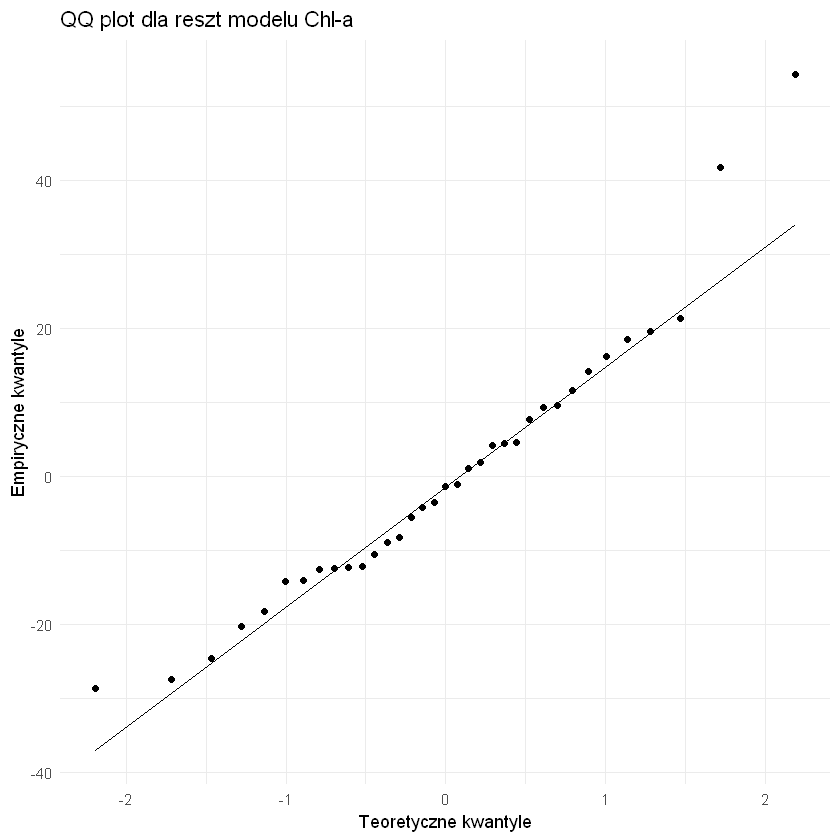

In [43]:
# wykres QQ dla reszt
residuals_chla %>%
    ggplot(aes(sample = reszty)) +
    stat_qq() +
    stat_qq_line() +
    labs(title = "QQ plot dla reszt modelu Chl-a",
         x = "Teoretyczne kwantyle",
         y = "Empiryczne kwantyle") +
    theme_minimal()

QQ plot dla reszt modelu Chlorofilu wskazuje, że reszty są bliskie rozkładowi normalnemu, z wyjątkiem dwóch punktów na końcu rozkładu. Wartości te mogą sugerować obecność skrajnych obserwacji, które mogą wpłynąć na wyniki analizy.

In [44]:
#| code-fold: false
# test Jarque-Bera dla reszt
jarque_bera_test_chla <- jarque.bera.test(residuals_chla$reszty)
jarque_bera_test_chla


	Jarque Bera Test

data:  residuals_chla$reszty
X-squared = 6.7808, df = 2, p-value = 0.0337


Na podstawie wyniku testu Jarque Bera można stwierdzić:

- Ponieważ wartość p (p-value = 0.0337) jest mniejsza niż typowy poziom istotności (np. 0.05), mamy podstawy do odrzucenia hipotezy zerowej.
- Hipoteza zerowa (H₀): Reszty mają rozkład normalny.
- W tym przypadku nie można przyjąć, że reszty są zgodne z rozkładem normalnym.

#### Homoskedastyczność

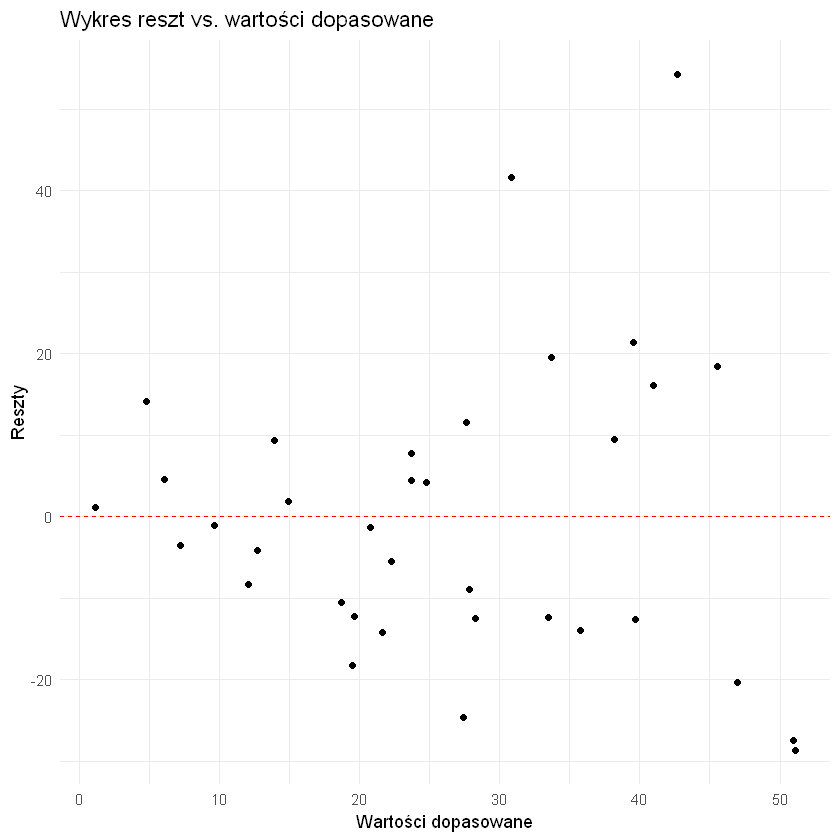

In [45]:
# wykres reszt vs. wartości dopasowane (homoskedastyczność)
residuals_chla %>%
    ggplot(aes(x = wpasowanie, y = reszty)) +
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(title = "Wykres reszt vs. wartości dopasowane",
         x = "Wartości dopasowane",
         y = "Reszty") +
    theme_minimal()

Na wykresie można zaobserwować, że reszty na początku mają mniejszy rozrzut, a następnie zwiększa się ich wariancja. Oznacza to, że wariancja reszt nie jest stała, co sugeruje brak homoskedastyczności.

#### Autokorelacja reszt

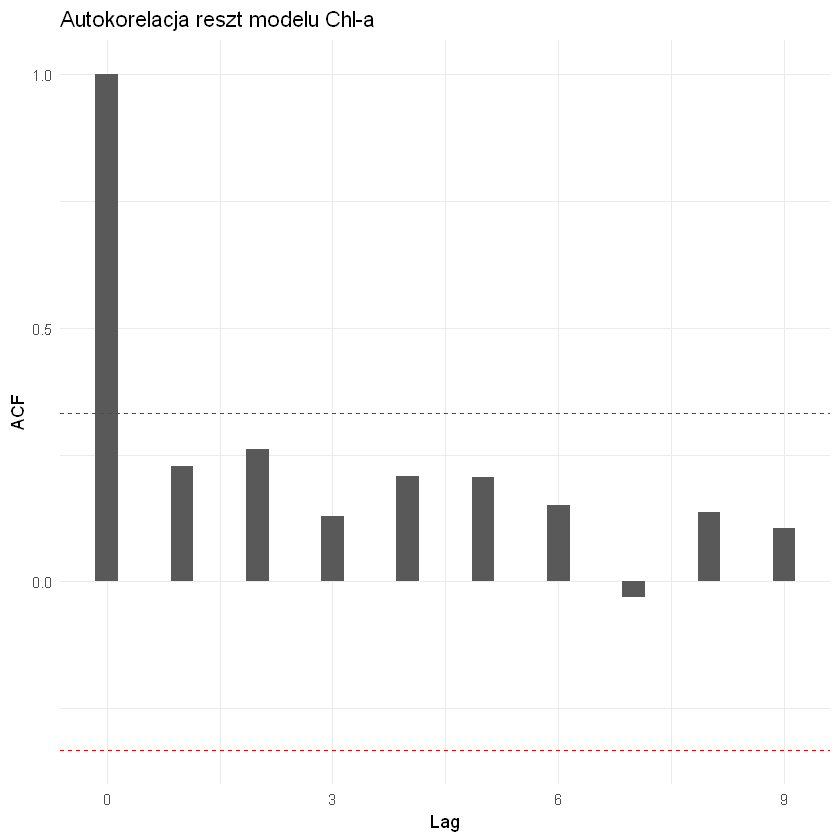

In [46]:
# autokorelacja reszt
plot_acf_residuals(residuals_chla$reszty, "Autokorelacja reszt modelu Chl-a")

Na wykresie autokorelacji reszt można zauważyć, że wszystkie wartości autokorelacji mieszczą się w przedziale ufności, co sugeruje brak autokorelacji. Oznacza to, że reszty nie są ze sobą skorelowane i nie występuje zależność między nimi.

#### Wpływ wartości odstających

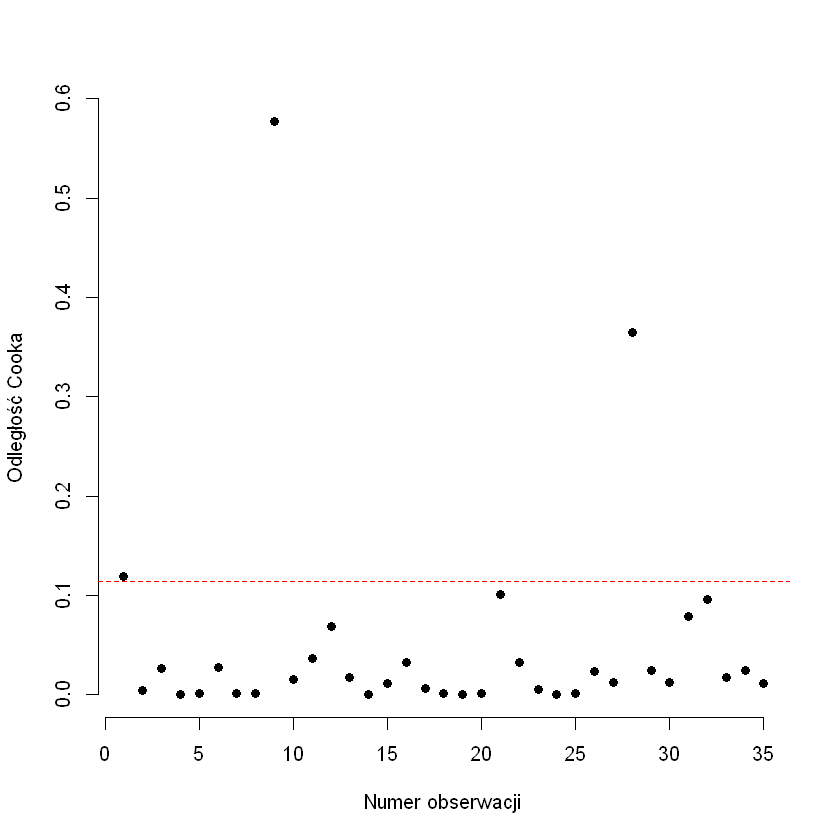

In [47]:
# Obliczanie odległości Cooka
cooks_distance_chla <- cooks.distance(chla_model)

# Wykres odległości Cooka
plot(cooks_distance_chla, pch = 19, frame = FALSE, xlab = "Numer obserwacji", ylab = "Odległość Cooka")
abline(h = 4 / nrow(dane_treningowe), col = "red", lty = 2)

Na wykresie można zauważyć, że 2 obserwacje znacząco wykraczają poza zakres wartości reszt. Wartości te mogą wpływać na jakość modelu. Pozostałe wartości odległości od prostej regresji są niewielkie, co sugeruje, że reszty są w miarę stabilne.

#### Zdolność predykcyjna modelu

Warning message in predict.lm(chla_model, dane_testowe):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


RMSE,MAE,MSE,R2,Korelacja.Pearsona,Korelacja.Spearmana,Korelacja.Kendall
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
13.55824,11.46468,183.8258,-1.610911,0.6217532,0.6411765,0.4666667


[ Note: You did not provide dates, so only a numeric index will be used in the time axis ]



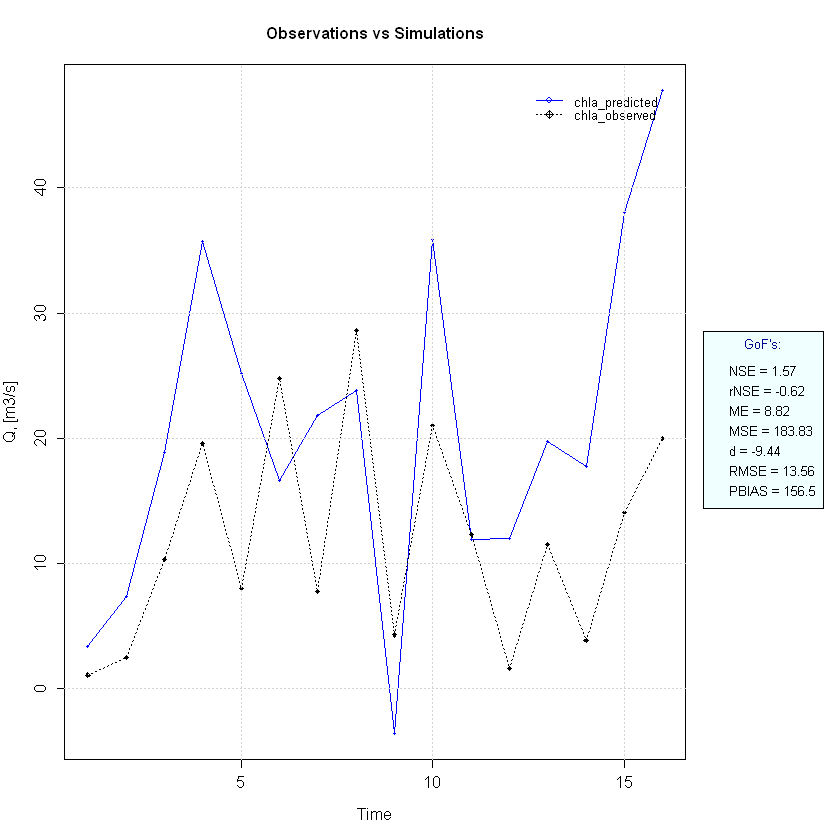

In [48]:
# porównanie modelu Chl-a z danymi testowymi
chla_predicted <- predict(chla_model, dane_testowe)
chla_observed <- dane_testowe$chla

# tabela z wynikami parametrów modelu
chla_model_results <- data.frame(
    RMSE = rmse(chla_predicted, chla_observed),
    MAE = mae(chla_predicted, chla_observed),
    MSE = mse(chla_predicted, chla_observed),
    R2 = R2(chla_predicted, chla_observed),
    "Korelacja Pearsona" = cor(chla_predicted, chla_observed),
    "Korelacja Spearmana" = cor(chla_predicted, chla_observed, method = "spearman"),
    "Korelacja Kendall" = cor(chla_predicted, chla_observed, method = "kendall")
)

chla_model_results <- tibble(chla_model_results)
chla_model_results

# hydroGOF
ggof(chla_predicted, chla_observed,
    gofs = c("NSE", "rNSE", "ME", "MSE",  "d", "RMSE", "PBIAS"),
    FUN = mean)

Model nie radzi sobie dobrze z przewidywaniem wartości chlorofilu. Niska jakość dopasowania (R² ujemne) i umiarkowane korelacje wskazują na potrzebę poprawy modelu, np. poprzez zmianę zestawu predyktorów, transformację zmiennych, zwiększenie ilości danych lub zastosowanie bardziej zaawansowanych technik modelowania.

#### Wnioski dotyczące modelu regresji liniowej dla Chlorofilu

Gdy analizujemy model regresji liniowej dla zmiennej, która nie została skonstruowana jako liniowa kombinacja innych zmiennych, oczekujemy, że wyniki będą mniej jednoznaczne i bardziej zróżnicowane. W przypadku modelu dla `chla` brak istotnych zależności między zmiennymi sugeruje, że dane te mogą być trudniejsze do przewidzenia i wymagać bardziej złożonych modeli lub dodatkowych zmiennych. Wykres odległości Cooka wskazuje wyraźnie na dwie obserwacje, które znacząco wpływają na model, ewentualne usunięcie tych obserwacji może poprawić jakość modelu, jednak należy to zrobić ostrożnie, aby nie utracić istotnych informacji. Te dwie obserwacje były widoczne również na wykresie QQ plot.

## Regresja liniowa z wszelkich możliwych kombinacji zmiennych

### Utworzenie macierzy binarnej, do tworzenia kombinacji zmiennych

In [49]:
#| code-fold: false
# Tworzenie ramki danych z wszelkimi możliwymi kombinacjami wartości 0 i 1 dla 7 kolumn
kombinacje <- expand.grid(rep(list(c(0, 1)), 7))
colnames(kombinacje) <- paste0("V", 1:7)

#  wyrzucenie pierwszego wiersza, który zawiera same zera
kombinacje <- kombinacje[-1, ]

head(kombinacje)

,V1,V2,V3,V4,V5,V6,V7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0
4,1,1,0,0,0,0,0
5,0,0,1,0,0,0,0
6,1,0,1,0,0,0,0
7,0,1,1,0,0,0,0


### Regresja liniowa z wszystkimi możliwymi kombinacjami zmiennych

New names:
• `` -> `...1`
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`
• `` -> `...14`
• `` -> `...15`
• `` -> `...16`
• `` -> `...17`
• `` -> `...18`
• `` -> `...19`
• `` -> `...20`
• `` -> `...21`
• `` -> `...22`
• `` -> `...23`
• `` -> `...24`
• `` -> `...25`
• `` -> `...26`
• `` -> `...27`
• `` -> `...28`
• `` -> `...29`
• `` -> `...30`
• `` -> `...31`
• `` -> `...32`
• `` -> `...33`
• `` -> `...34`
• `` -> `...35`
• `` -> `...36`
• `` -> `...37`
• `` -> `...38`
• `` -> `...39`
• `` -> `...40`
• `` -> `...41`
• `` -> `...42`
• `` -> `...43`
• `` -> `...44`
• `` -> `...45`
• `` -> `...46`
• `` -> `...47`
• `` -> `...48`
• `` -> `...49`
• `` -> `...50`
• `` -> `...51`
• `` -> `...52`
• `` -> `...53`
• `` -> `...54`
• `` -> `...55`
• `` -> `...56`
• `` -> `...57`
• `` -> `...58`
• `` -> `...59`
• `` -> `...60`
• `` -> `...61`
• `` -> `...62`
• `` -

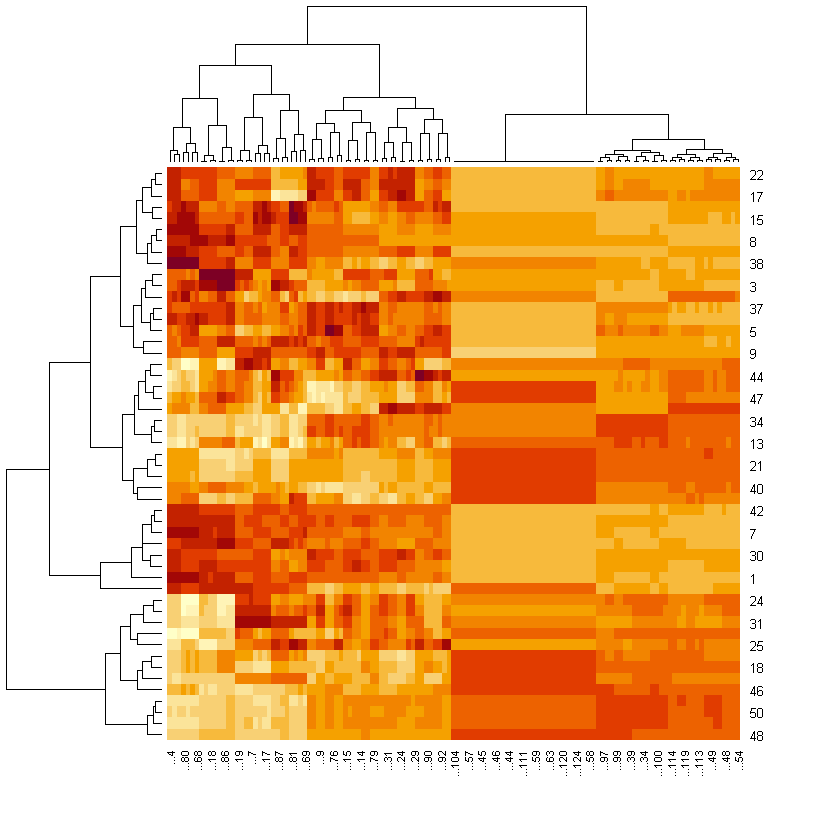

In [50]:
#| code-fold: false
modelowana_kolumna <- "ITS"
# kolumny do analizy bez wybranej kolumny
predyktory <- setdiff(kolumny_do_analizy, modelowana_kolumna)

# funkcja, która zwraca wyniki predykcji dla danej kombinacji
predict_for_combination <- function(combination, data, model_variable, predictors) {
    predictors <- predictors[combination == 1]
    model <- lm(as.formula(paste(model_variable, "~", paste(predictors, collapse = " + "))), data = data)
    predicted <- predict(model, data)
    return(predicted)
}

# utworzenie ramki danych z wynikami predykcji dla każdej kombinacji, liczba kolumn zależy od liczby zwróconych predykcji   
predictions <- map_dfc(1:nrow(kombinacje), ~predict_for_combination(kombinacje[.x, ], dane, modelowana_kolumna, predyktory))

# wizualizacja za pomocą mapy ciepła
heatmap(as.matrix(predictions))

Na podstawie wyników regresji liniowej z wszystkimi możliwymi kombinacjami zobrazowanych za pomocą heatmapy można stwierdzić, że istnieją kombinacje zmiennych, które będą miały bardzo podobne wyniki, co sugeruje, że niektóre zmienne mogą być zbędne w modelu.

### Tile plot do wizualizacji wszystkich wyników regresji uzyskanych z kombinacji zmiennych

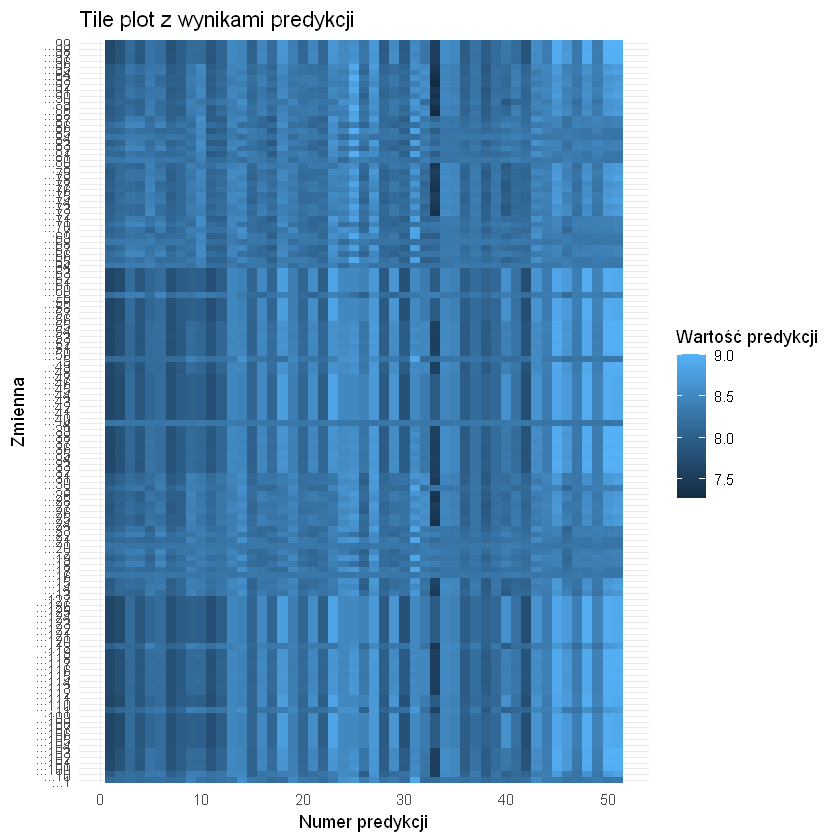

In [51]:
# tile plot z wynikami predykcji
predictions_long <- predictions %>% 
    mutate(numer_predykcji = row_number()) %>% 
    pivot_longer(cols = -numer_predykcji, names_to = "zmienna", values_to = "wartosc")

ggplot(predictions_long, aes(x = numer_predykcji, y = zmienna, fill = wartosc)) +
    geom_tile() +
    labs(title = "Tile plot z wynikami predykcji",
         x = "Numer predykcji",
         y = "Zmienna",
         fill = "Wartość predykcji") +
    theme_minimal()

Na podstawie tile plot można zauważyć, że niektóre kombinacje zmiennych słabo radzą sobie z predykcją wartości ITS, w porównaniu do większości innych kombinacji. Można stwierdzić, że jest to około 15% wszystkich kombinacji zmiennych. Prawdopodobnie te kombinacje nie zawierają `ph` lub `nas`, które są kluczowe dla predykcji ITS.

### Jitter plot do wizualizacji wszystkich wyników regresji uzyskanych z kombinacji zmiennych, z wyróżnieniem rzeczywistych wartości

Rzeczywiste wartości `ITS` są zaznaczone na wykresie jako większe żółte punkty, punkty w pozostałych kolorach reprezentują predykcje modelu dla danej kombinacji zmiennych.

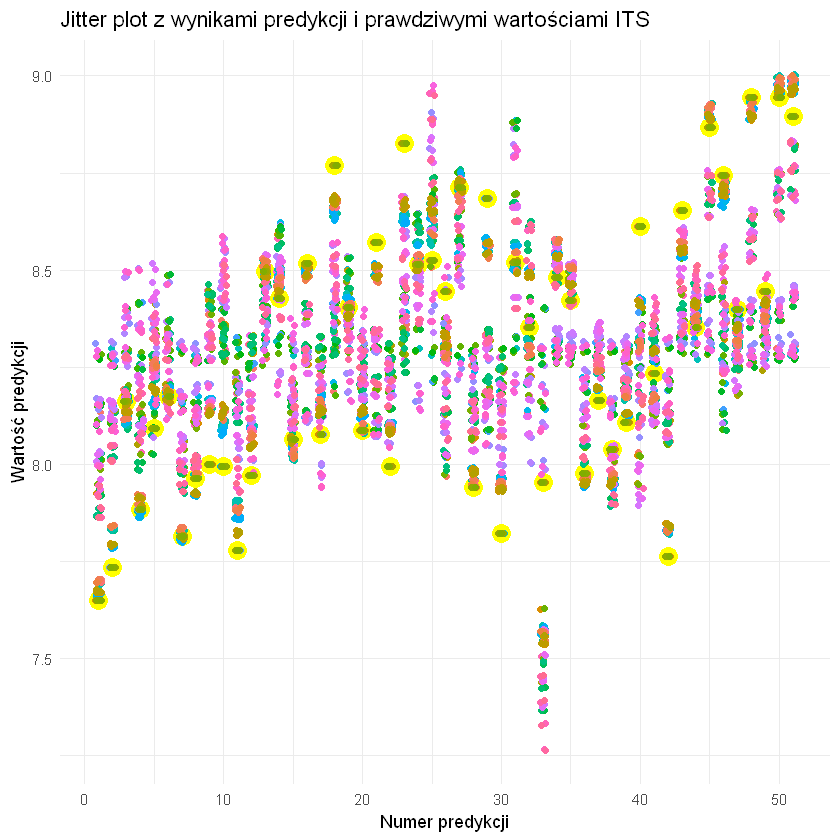

In [52]:
# jitter plot z wynikami predykcji z prawdziwymi wartościami ITS
ggplot(predictions_long, aes(x = numer_predykcji, y = wartosc, color = zmienna)) +
    geom_point(data = dane, aes(x = 1:nrow(dane), y = ITS), color = "yellow", size = 5) +
    geom_jitter(width = 0.2, height = 0) +
    labs(title = "Jitter plot z wynikami predykcji i prawdziwymi wartościami ITS",
         x = "Numer predykcji",
         y = "Wartość predykcji",
         color = "Zmienna") +
    theme_minimal() +
    theme(legend.position = "none")

 Na podstawie wykresu można stwierdzić, że niektóre kombinacje zmiennych lepiej przewidują wartości `ITS`, podczas gdy inne mają większe odchylenia od rzeczywistych wartości.

## Predykcja ITS i Chlorofilu za pomocą SVM

### Utowrzenie modelu SVM oraz wizualizacja wpasowania modelu

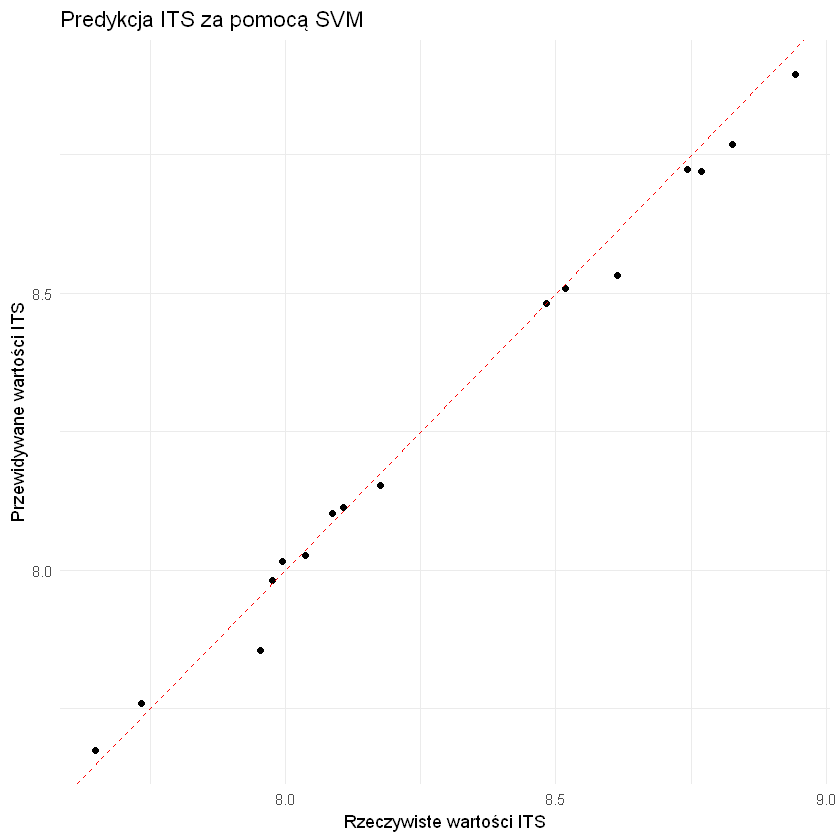

In [53]:
# Predykcja ITS za pomocą metody SVM

# trenowanie modelu
model_svm <- svm(ITS ~ ., data = dane_treningowe, kernel = "linear")

# predykcja
predicted_svm <- predict(model_svm, dane_testowe)

# tablica kontyngencji
tablica_kontyngencji <- table(predicted_svm, dane_testowe$ITS)

# wizualizacja wyników predykcji
ggplot(dane_testowe, aes(x = ITS, y = predicted_svm)) +
	geom_point() +
	geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
	labs(title = "Predykcja ITS za pomocą SVM",
		 x = "Rzeczywiste wartości ITS",
		 y = "Przewidywane wartości ITS") +
	theme_minimal()


Dzięki wizualizacji można stwierdzić, że model SVM dla predykcji ITS dobrze dopasowuje się do danych treningowych, co sugeruje, że model jest w stanie przewidzieć wartości ITS na podstawie dostępnych zmiennych.

### Predykcja ITS za pomocą modelu SVM

[ Note: You did not provide dates, so only a numeric index will be used in the time axis ]



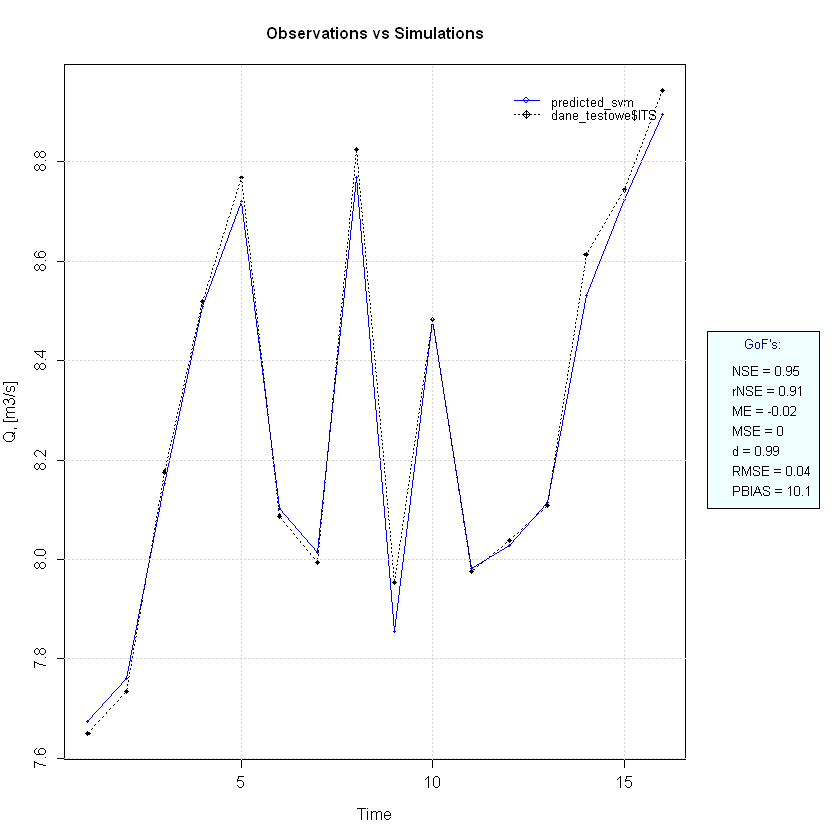

In [54]:
# ocena predykcji za pomocą hydroGOF

ggof(predicted_svm, dane_testowe$ITS,
    gofs = c("NSE", "rNSE", "ME", "MSE",  "d", "RMSE", "PBIAS"),
    FUN = mean)     

Możemy zaobserwować, że model SVM dobrze przewiduje wartości ITS i przy okazji zwrócić uwagę na statystyki oceny jakości modelu, które wskazują na wysoką skuteczność predykcji.

### Utowrzenie modelu SVM oraz wizualizacja wpasowania modelu

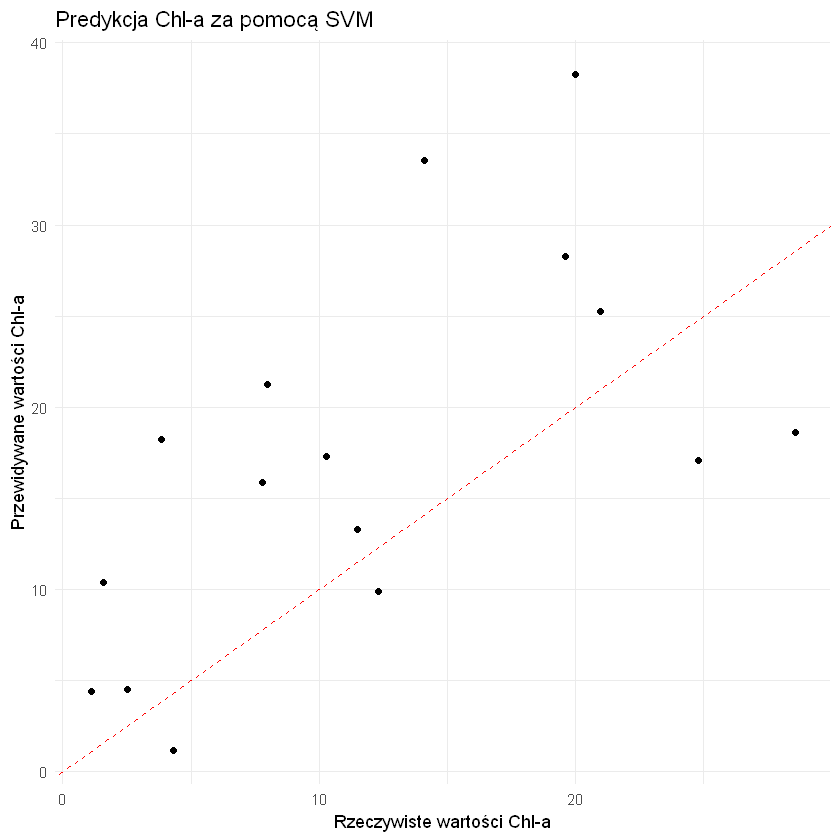

In [55]:
# Predykcja Chlorofilu za pomocą metody SVM

# trenowanie modelu
model_svm_chla <- svm(chla ~ ., data = dane_treningowe, kernel = "linear")

# predykcja
predicted_svm_chla <- predict(model_svm_chla, dane_testowe)

# tablica kontyngencji
tablica_kontyngencji_chla <- table(predicted_svm_chla, dane_testowe$chla)

# wizualizacja wyników predykcji
ggplot(dane_testowe, aes(x = chla, y = predicted_svm_chla)) +
    geom_point() +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
    labs(title = "Predykcja Chl-a za pomocą SVM",
         x = "Rzeczywiste wartości Chl-a",
         y = "Przewidywane wartości Chl-a") +
    theme_minimal()

Na podstawie wizualizacji można stwierdzić, że model SVM dla predykcji Chlorofilu nie sprawdza się. Punkty na wykresie są rozproszone w sposób losowy względem linii, co sugeruje, że model nie jest w stanie przewidzieć wartości Chlorofilu na podstawie dostępnych zmiennych.

[ Note: You did not provide dates, so only a numeric index will be used in the time axis ]



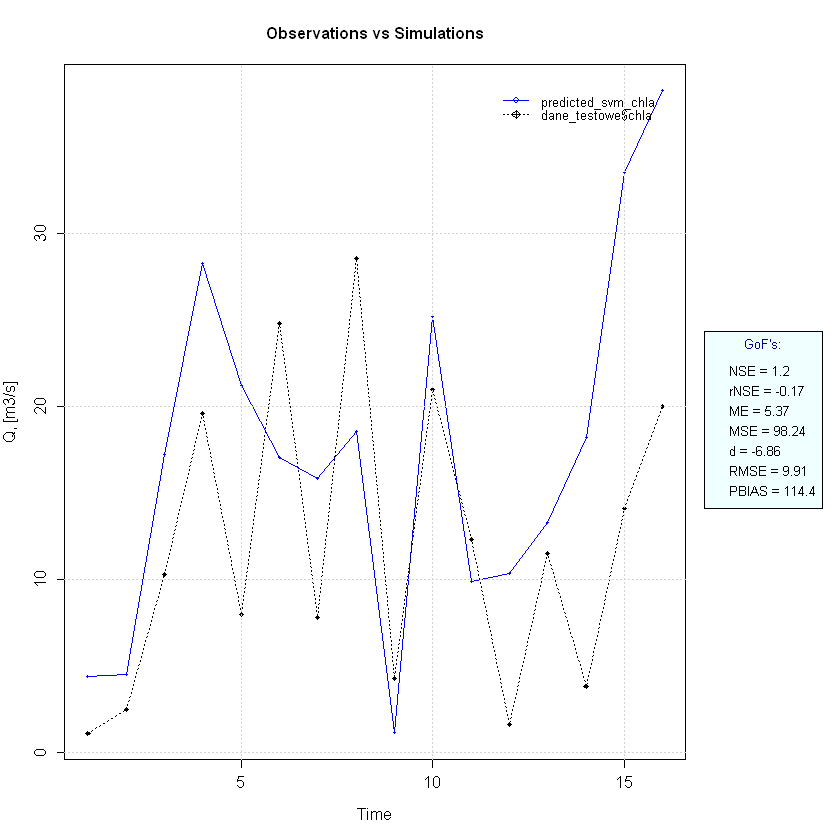

In [56]:
# ocena predykcji za pomocą hydroGOF

ggof(predicted_svm_chla, dane_testowe$chla,
    gofs = c("NSE", "rNSE", "ME", "MSE",  "d", "RMSE", "PBIAS"),
    FUN = mean)

Możemy zaobserwować jak wyglądają dysproporcje między wartościami rzeczywistymi a przewidywanymi przez model SVM dla Chlorofilu. Dodatkowo, warto zwrócić uwagę na statystyki oceny jakości modelu, które wskazują na niską skuteczność predykcji.

## Końcowe wnioski

Na podstawie przeprowadzonych analiz można wyciągnąć następujące wnioski:

1. **Testy wartości odstających**: Przeprowadzone testy Grubbsa, Dixona zostały poparte metodą IQR. Jednak przy wyrzucaniu wartości odstających z danych, należy zachować ostrożność i zwrócić uwagę na potencjalne błędy pomiarowe lub specyficzne przypadki w danych.

2. **Korelacje**: Zarówno korelacja Pearsona, jak i Spearmana potwierdziły istnienie silnych zależności między określonymi parami zmiennych. Jednak analiza korelacji Spearmana pozwoliła na identyfikację dwóch dodatkowych związków, o około 0,1 silniejszych, z udziałem zmiennej `chla`.

3. **Autokorelacja**: W analizie autokorelacji nie wykryto istotnych zależności, co sugeruje, że wartości w szeregu czasowym nie są ze sobą skorelowane.

4. **Regresja liniowa**: Model regresji liniowej dla zmiennej `ITS` okazał się bardzo skuteczny, co nie jest zaskakujące, biorąc pod uwagę liniową zależność między `ITS`, `ph` i `nas`. Natomiast model dla zmiennej `chla` nie wykazał istotnych zależności, co sugeruje, że dane te mogą być trudniejsze do przewidzenia.

5. **Regresja z kombinacjami zmiennych**: Analiza regresji z wszystkimi możliwymi kombinacjami zmiennych pokazała, że wybór odpowiednich zmiennych jest kluczowy dla skuteczności modelu. Niektóre kombinacje zmiennych radzą sobie lepiej z predykcją wartości `ITS`, podczas gdy inne mają większe odchylenia od rzeczywistych wartości.

6. **SVM**: Model SVM dla predykcji `ITS` okazał się skuteczny, co potwierdza wysoką jakość predykcji. Natomiast model dla predykcji `chla` nie sprawdził się, co sugeruje, że dane te mogą być trudniejsze do przewidzenia.

